# Statistical Optimisation & Data Assimilation Methods

- Static version of these slides available at: jrper.github.io/rv/da.html
- A Jupyter book version of the material (including extra content) is available at ese-msc-2023.github.io/data-assimilation-notes

j.percival@imperial.ac.uk
RSM 4.94

In [1]:
# key modules

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
make_plots= False

Plan for this section:
- Probability recap (about 20 minutes)
- Random number generation on computers(about 15 minutes inc. rant!)
- Statistical interpolation: The BLUE & Optimal Interpolation
- Variational interpolation & the Data Assimilation cost function
- About time - the Kalman Filter
- 4D Var & Ensemble Kalman filter
  - will stop at 12 regardless

## Probability Recap

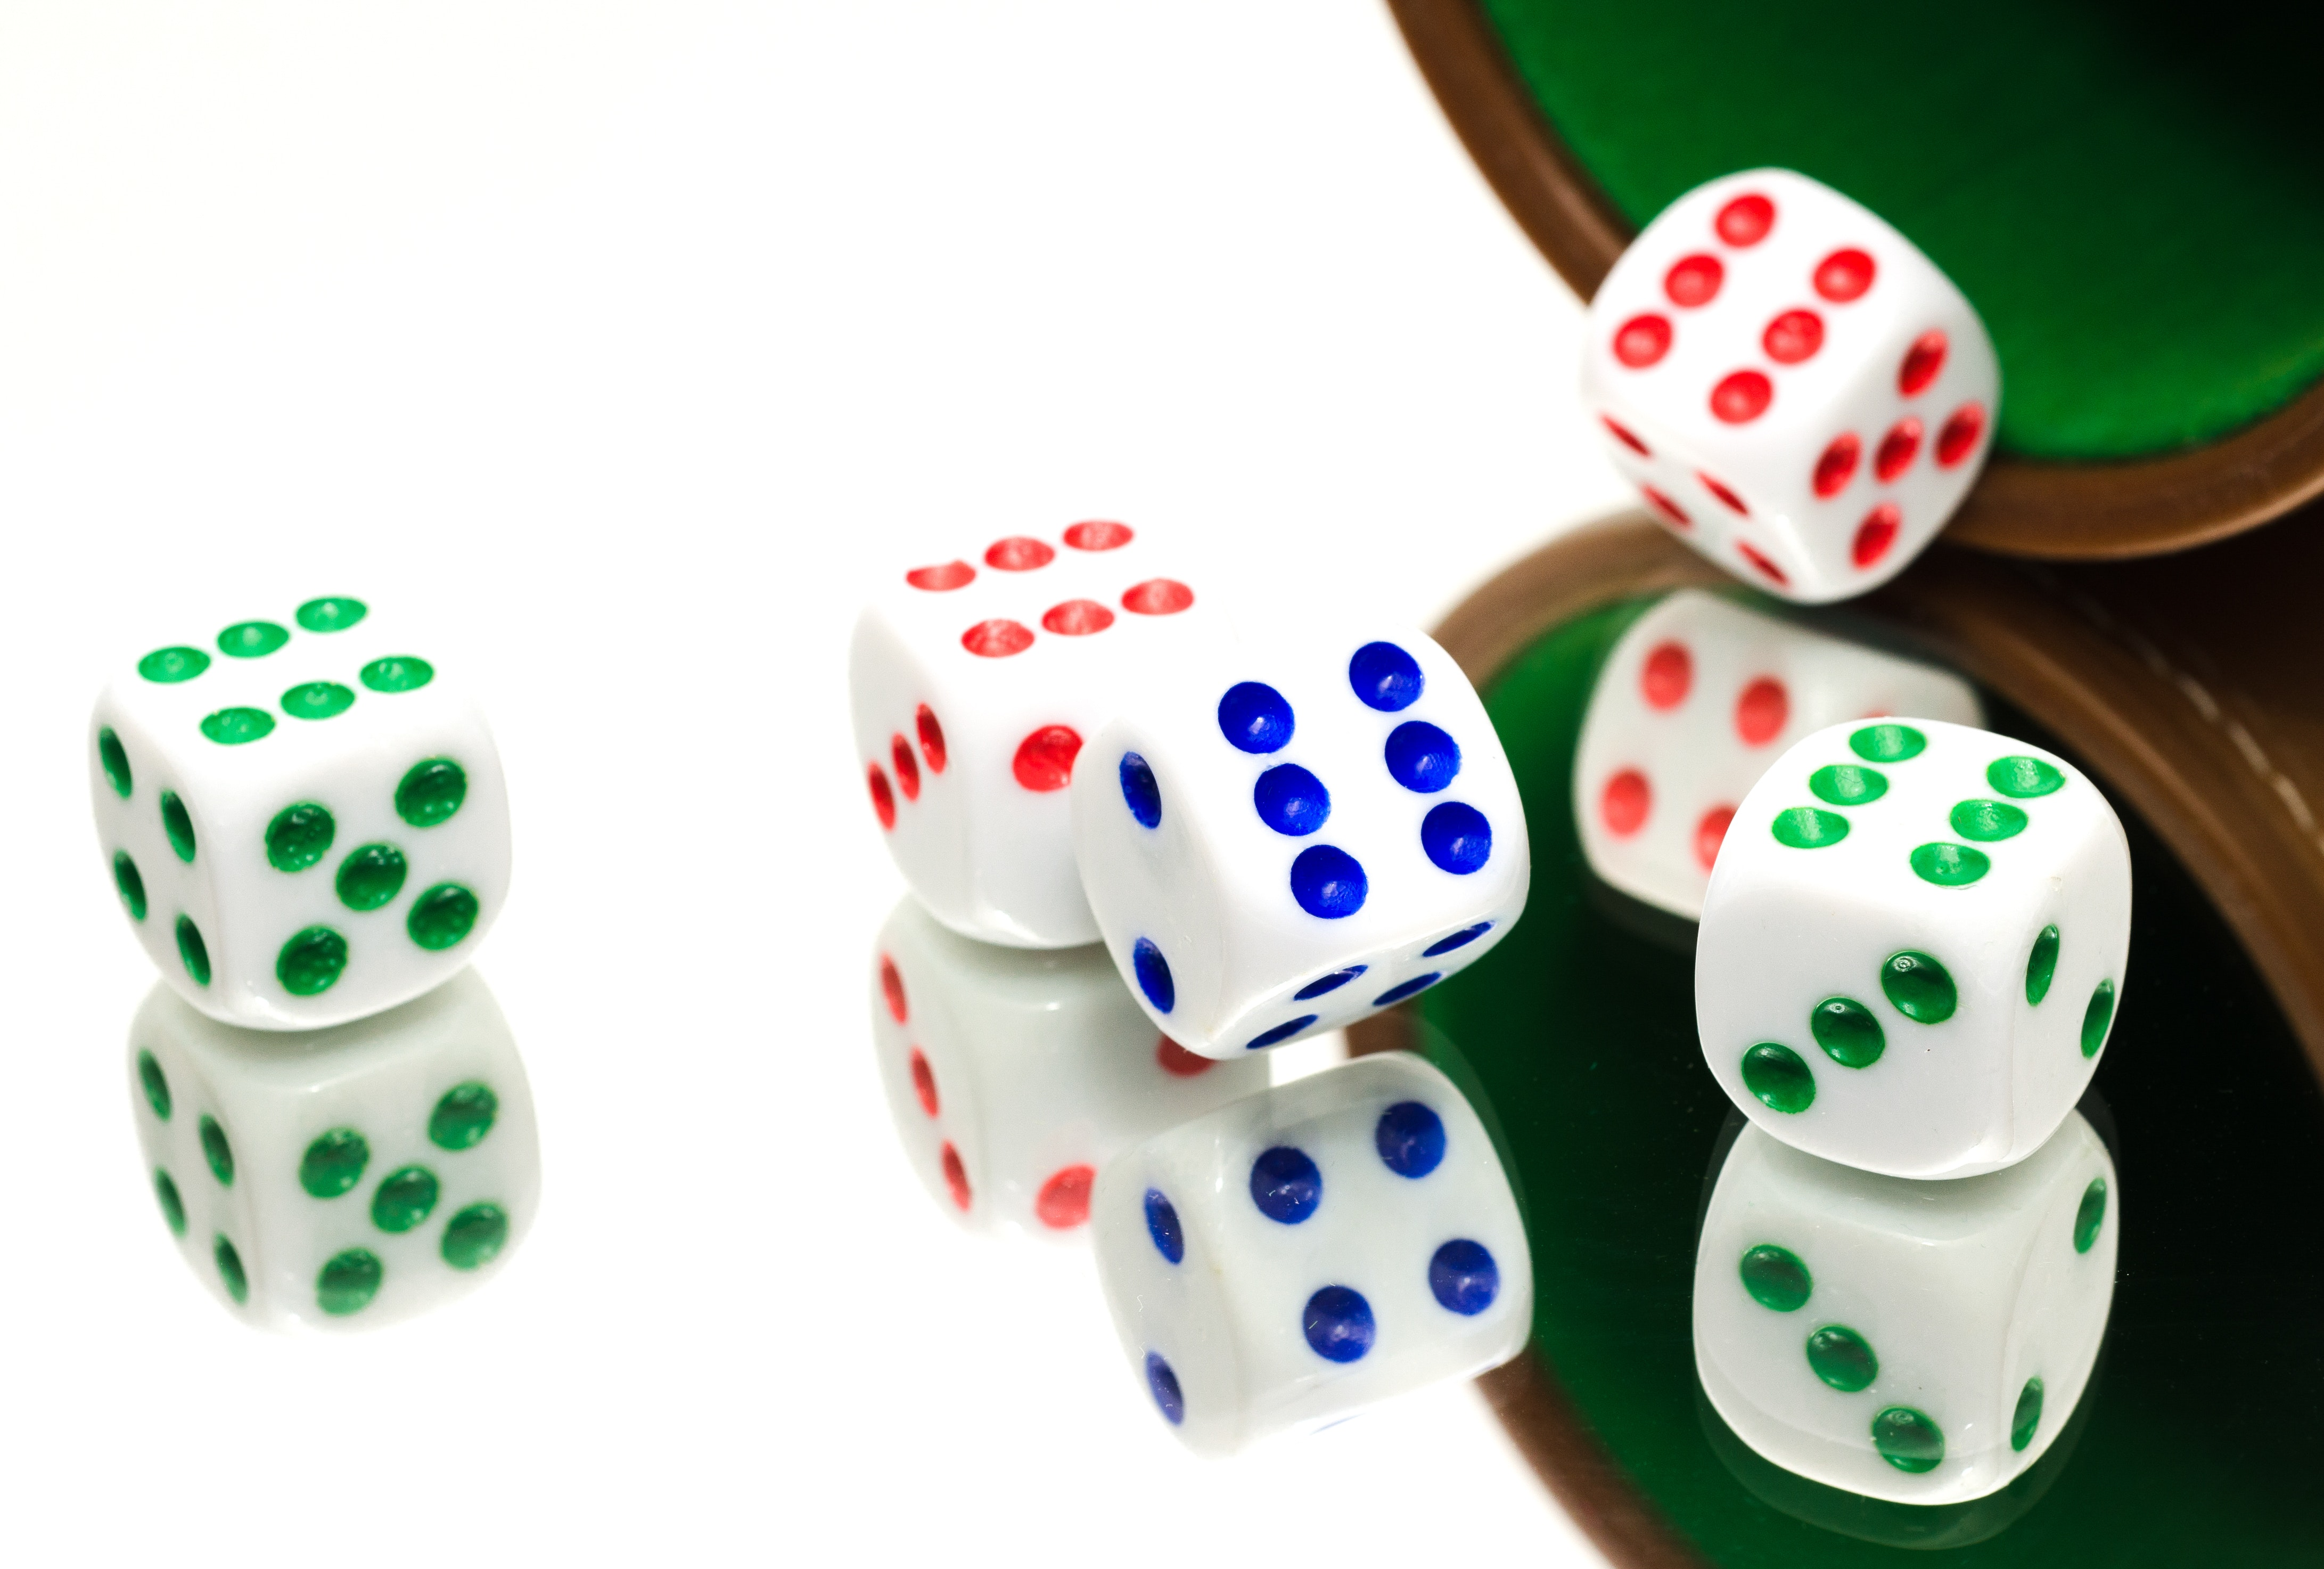

### Probability Recap

- "Chance" that discrete random event, $X$, is described by label $x$ is written $P(X=x)$.
- For a continuous random event, "chance" $X$ is in interval $S$ is $P(X\in S)$  
  - e.g $P(0.2\leq x <0.4)$
- If we're lucky, we can write $P(X\in S)$ = $\int_{S}p(x) dx$ for some $p(x)$.



- We often choose to be lucky.
- Famous distributions:
    - **Uniform** on interval [a, b]
       $$p(x;a, b) = \begin{cases} \frac{1}{b-a} & a\leq x < b\\0& \textrm{otherwise}\end{cases}$$
    - **Gaussian/Normal** with mean $\mu$, s.d $\sigma$
       $$ p(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$
    - **logistic** with mean $\mu$, s.d $\sigma$
      $$p(x; \mu, \sigma) =  \frac{1}{{4\sigma}}\textrm{sech}^2 \left(\frac{x-\mu}{2\sigma}\right)$$
    

In [2]:
x = np.linspace(-3, 3, 100)

def uniform(x, a, b):
    return np.where((x>=a)*(x<b), 1/(b-a), 0)

def normal (x, mu, sigma):
    return np.exp(-0.5*(x-mu)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)

def logistic(x, mu, sigma):
    return 1/np.cosh((x-mu)/(2*sigma))**2/(4*sigma)

In [3]:
if make_plots or False:
    plt.title('PDFs')
    plt.plot(x, uniform(x, -0.5, 1.5), label='Uniform(-0.5, 1.5)')
    plt.plot(x, normal(x, 0, 1), label='Normal(0,1)')
    plt.plot(x, logistic(x, 0, 1), label='Logistic(0,1)')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$p(x)$')
    plt.legend()
    plt.savefig('images/PDFs.png')

<img src="./images/PDFs.png" style="height:35cm;align:center">

### Likelihood

- Can also view PDFs as multivariate functions of a fixed outcome, $x$, fixed parameters & some free parameter(s):
  - **Uniform** (lower bound) 
  $$l(a; x, b) = \begin{cases}\frac{1}{b-a} & a < x\\0& \textrm{otherwise}\end{cases}$$
  - **Gaussian/Normal** (mean),
  $$ p(\mu; x, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\mu-x)^2}{2\sigma^2}\right)$$
  - **logistic** (mean) 
  $$p(\mu; x,  \sigma) =  \frac{1}{{4\sigma}}\text{sech}^2 \left(\frac{\mu-x}{2\sigma}\right)$$

In [4]:
theta = np.linspace(-3, 3)
x0=0

if make_plots or False:
    plt.title('likelihoods (for $x=0$)')
    plt.plot(theta, uniform(x0, theta, 1.5), label='Uniform - a likelihood, with b=1.5')
    plt.plot(theta, normal(x0, theta, 1), label='Normal - mean likelihood')
    plt.plot(theta, logistic(x0, theta, 1), label='Logistic - mean likelihood')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$l(\theta)$')
    plt.legend()
    
    plt.savefig('images/likelihoods.png')

<img src="./images/likelihoods.png" style="height:35cm;align:center">

- Sum of Gaussians distributions is also Gaussian distributed independent of means/variances
$$P(X+Y<z)=\int^z p_{X+Y} dz'  = \int^z\frac{1}{\sqrt{2\pi(\sigma_X^2+\sigma_Y^2)}}\exp \left( -\frac{(z-\mu_X-\mu_Y)^2}{2(\sigma^2_X+\sigma^2_Y)} \right)dz' $$
- Not true for most other distributions!
- Not true for multiplication/nonlinear functions

## Multivariate Gaussian

- Consider vector, $\mathbf{z}$ of independent $\mathcal{N}(0,1)$ normal distributions.
- Joint distribution
$$p(\mathbf{z}) = \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{\|\mathbf{z}\|^2}{2}\right) $$

$$ P(Z_1\leq z_1, \ldots, Z_n\leq z_n) = \int_{-\infty}^{z_1} \ldots \int_{-\infty}^{z_n} p(\mathbf{z}) dz_n \ldots dz_1 .$$

- More generally, thanks to summation/variance rules, have a formula given mean & covariance _matrix_
$$p(\mathbf{z}) = \frac{1}{\sqrt{2\pi\det{\mathbf{S}}}}\exp\left(\frac{(\mathbf{z}-\mathbf{\mu})^T\mathbf{S}^{-1}(\mathbf{z}-\mathbf{\mu})}{2}\right) $$

### What does chance mean anyway? Classical view

 _Classical_ probability is ratio of successes to cases, where all cases "equally likely":

$$ \textrm{possible results} = \{1, 2, 3, 4, 5, 6\} $$

$$ \textrm{results divisible by 3} = \{3, 6\}$$

$$ P(\textrm{result divisible by 3}) = \frac{2}{6} \approx 0.3333 $$

In [5]:
# Pythons standard random number library
import random
def d6():
    """A Python implementation of a six sized dice"""
    # We could also use random.randrange(1, 7) or 
    # numpy's np.random.randint(1, 7)
    # (which will vectorize better).
    # note the different ways to set the endpoint
    return random.randint(1,6)

[d6() for _ in range(20)]

[6, 6, 2, 5, 2, 6, 5, 4, 5, 1, 1, 6, 3, 6, 1, 3, 5, 6, 4, 6]

In [6]:
# Set up a simple statistical test on our d6
def sample(n=1000):
    success = 0
    for i in range(n):
        # successful trial divides by 3 
        success += (d6()%3 == 0)
    # return the ratio of successes to failures
    return success/n

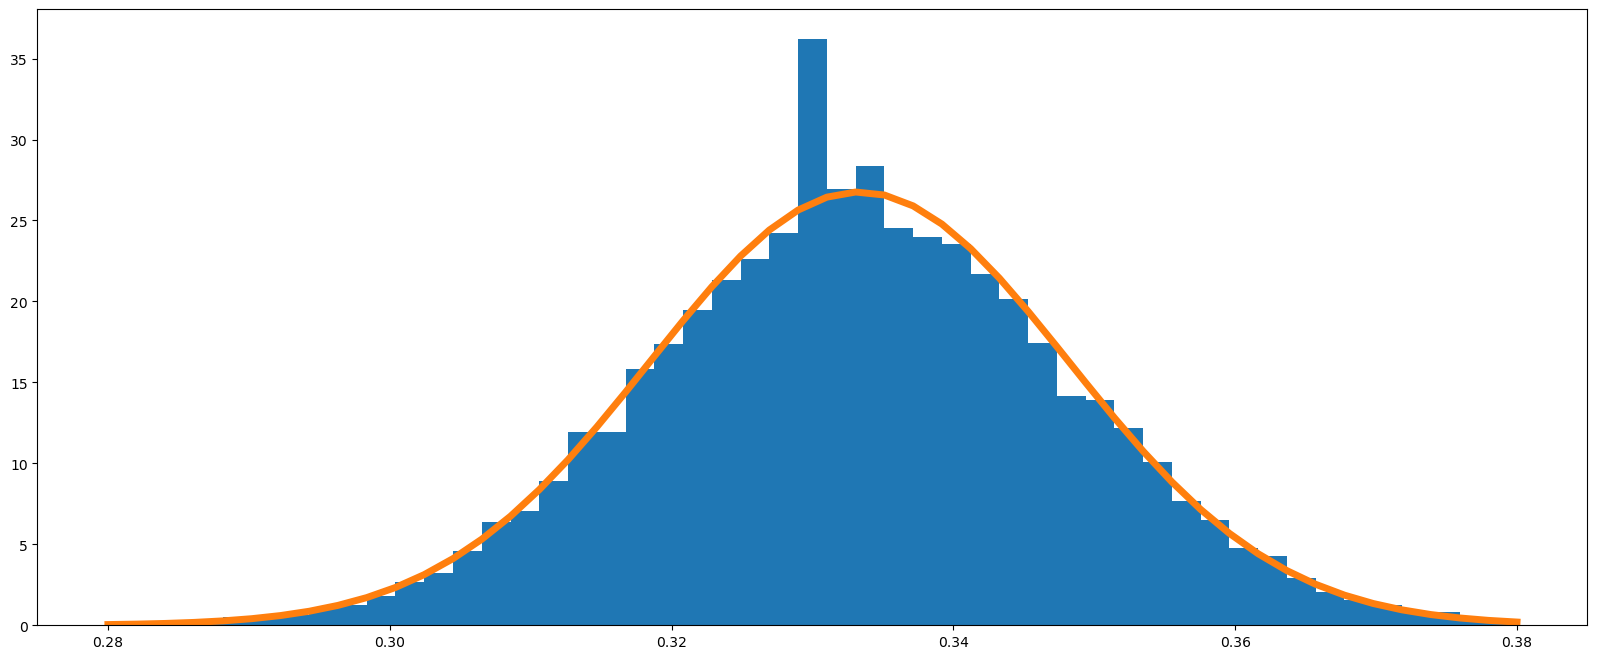

In [7]:
plt.figure(figsize=(20,8))
n1 = 1000 # number of samples in a trial
n2 = 10000 # number of trials
bins = np.linspace(0.28, 0.38, n1//20)
plt.hist([sample(n1) for _ in range(n2)], bins=bins, density=True);
x = np.linspace(0.28,0.38)
plt.plot(x, normal(x, 1/3, np.sqrt(2/(9*n1))), lw=5); # Central limit theorem

### Frequestist probability

- _Frequentist_ probability views P as the **limit** of **many trials**.
- explains what you'd expect to see "on average"/ in long term.
- Makes sense when things are repeated or aggregated
- Harder to justify in a single case
- View point of (say) statistical physics

0.3335418701171875

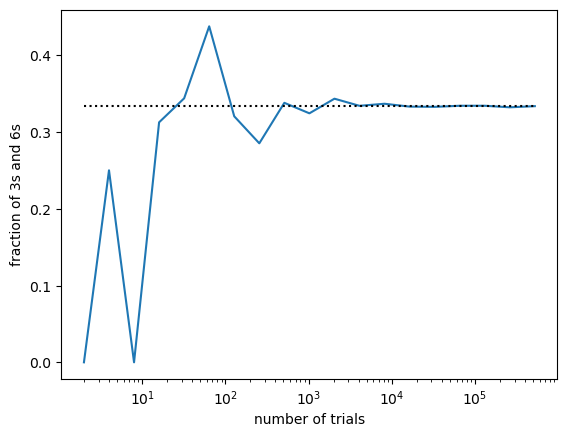

In [8]:
def f_n(N):
    return [sum([d6()%3==0 for _ in range(n)])/n for n in N]

x_vals = [2 **i for i in range(1,20)]
y_vals = f_n(x_vals)

plt.plot(x_vals, y_vals)
plt.hlines(1/3, x_vals[0], x_vals[-1], 'k', ls=':')
plt.xscale('log')
plt.xlabel('number of trials')
plt.ylabel('fraction of 3s and 6s')
y_vals[-1]

### Bayesian Probability

- _Bayesian_ probability is a statement of belief/certainty
- Transformed using the laws of probability
- Can be defined for **one event**
- Can be different for different observers
- Liable to update with new information (_prior_ $\rightarrow$ _posterior_)

#### Reminder: Bayes' Theorm

$$ P(A| B) = \frac {P(B | A) P( A)}{P(B)}  $$

Formula used to apply new knowledge.

Not sure if someone is British or American? Ask them if they want tea or coffee!

$$ P(\textrm{Is American} | \textrm{prefers coffee to tea}) = \frac{P(\textrm{prefers coffee to tea} | 
\textrm{Is American})P(\textrm{Is American})}{P(\textrm{Prefers coffee to tea})} $$
$$ \frac{200}{227} = \frac{\frac{2}{3}\frac{5}{6}}{\frac{2}{3}\frac{5}{6}+\frac{3}{8}\frac{1}{6}}$$
$$\tag{Bayesian} \textrm{Posterior estimate} \propto \textrm{Likelihood}\times \textrm{Prior estimate} $$
$$\tag{Bayesian} p(\theta|\textrm{new data}) \propto p(\textrm{new data}|\theta)p(\theta| \textrm{previous knowledge}) $$


Here normalisation factor (called **marginal likelihood**/**evidence**) is
$$\int_{\textrm{possible values of }\theta} p(\textrm{new data}|\theta) p(\theta) d\theta$$

same format as **expected value** (or **expectation**) operator, $\mathbb{E}$

$$\mathbb{E}(f(X)) := \int_{\textrm{possible values of }x} f(x) p(x) dx$$



### Mean, median, mode, variance

$$\tag{mean}\mu_X:=\mathbb{E}(X)$$
$$\mathbb{E}(\textrm{6 sided dice}) := \sum_{x=1}^6 x \frac{1}{6}=3.5$$
$$\tag{median (1d only)}  x \textrm { s.t. } P(X\leq x)=0.5$$
$$\tag{mode} \underset{x\in X}{\operatorname{argmax}\,} p(x)$$
$$\tag{variance}\sigma^2_X := \mathbb{E}((X-\mu)^2)$$
$$\quad\qquad=\mathbb{E}(X^2)-\mathbb{E}(X)^2$$



## Properties of the expectation operator

Fixed values stay fixed
$$\mathbb{E}(10) = 10$$
Linear in scalar multiplication
$$\mathbb{E}(3X) = 3\mathbb{E}(X)$$
distributes over addition
$$ \mathbb{E}(X+Y) = \mathbb{E}(X)+\mathbb{E}(Y) $$

Full proofs of these get surprisingly involved (and nobody ever expects you to write them down from scratch). E.g.

$$ \mathbb{E}(X+Y) = \sum_{x,y} (x+y)P(X=x\cap Y=y) $$
$$\qquad \qquad \qquad \qquad \qquad= \sum_{x,y} x P(X=x\cap Y=Y)+\sum_{x,y} y P(Y=x\cap X=x) $$

$$\sum_{x,y} x P(X=x\cap Y=Y)=\sum_{x,y} xP(x)(Y=y\vert X=x) $$
$$=\sum_x \left[xP(x)\underbrace{\sum_y(P(y\vert x)}_{=1}\right] =\sum_x  xP(x)=\mathbb{E}(X)$$

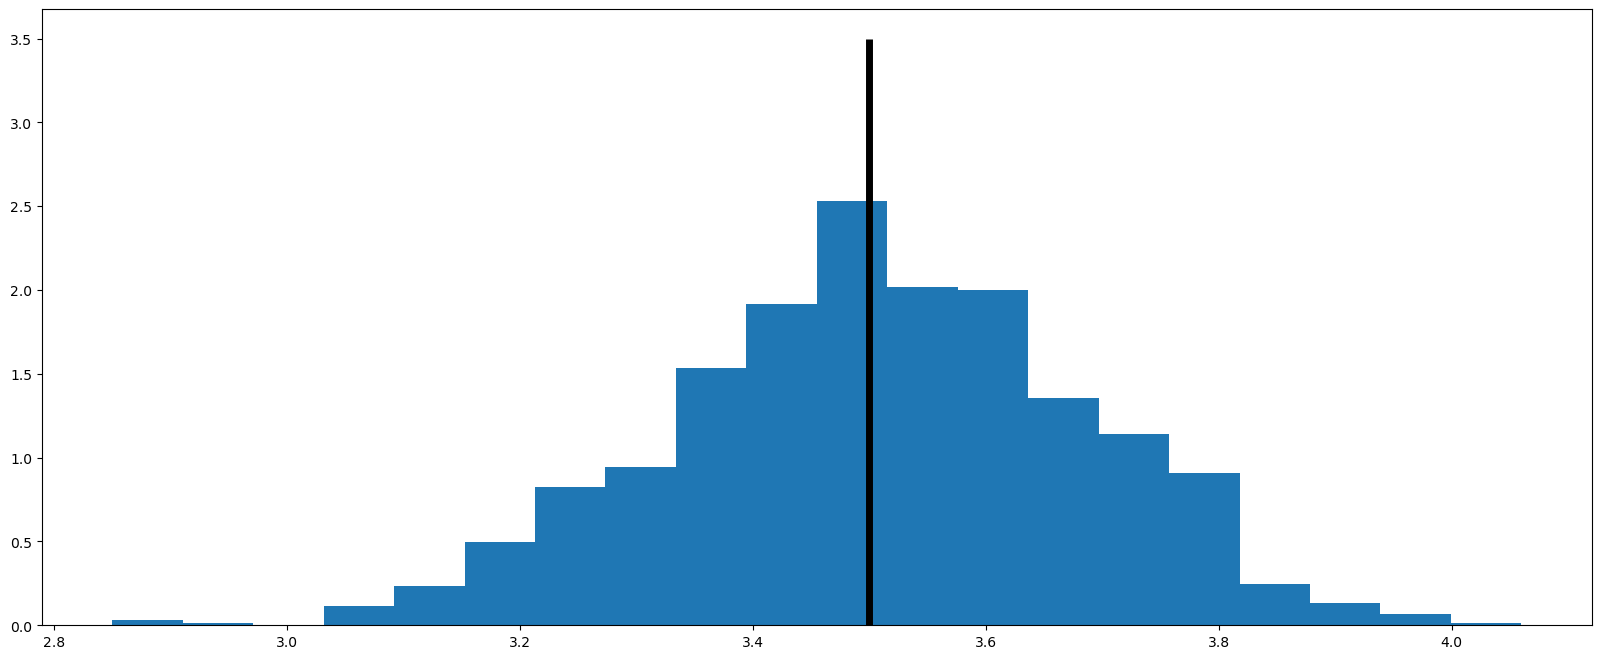

In [9]:
# Estimate mean from samples
n_samples = 100
mu = []
for _ in range(1000):
    data = np.array([d6() for i in range(n_samples)])
    mu.append(np.sum(data)/n_samples) # or just np.mean()
plt.figure(figsize=(20, 8))
plt.vlines(3.5, 0, 3.5, 'k', lw=5)
plt.hist(mu, bins=20, density=True);

### Estimators

Rule to give guess at a _parameter_ of random data distribution based on observed data/samples. Eg.

$$\tag{Sample mean} \frac{1}{n}\sum_{i=1}^n x_i \approx \mu_X .$$

Estimator $\hat{\xi}$ of property $\xi$ is **unbiased** if 

$$\mathbb{E}(\hat\xi)=\xi$$

i.e. it's right "on average".

$$\mathbb{E}\left(\frac{1}{n}\sum_{i=1}^n x_i\right) = \frac{1}{n}\sum_{i=1}^n \mathbb{E}(x_i) =  \mu_X .$$

Linked to ML definition of bias.

Taking similar approach for variances gives,
$$ \tag{population variance} \frac{\sum_{i=1}^n \left(x_i-\frac{\sum_{j=1}^n x_j}{n}\right)^2}{n}\approx \sigma^2_X$$

but
$$\mathbb{E}\left(\frac{\sum_{i=1}^n \left(x_i-\frac{\sum_{j=1}^n x_j}{n}\right)^2}{n}-\sigma^2_X\right)=\frac{\sigma^2_X}{n}$$
Simple variance estimator is **biased**.

a "better" (i.e unbiased) estimate for variance is
$$\tag{sample variance} \frac{\sum_{i=1}^n \left(x_i-\frac{\sum_{j=1}^n x_j}{n}\right)^2}{n-1}$$
for some distributions this will tend to have a higher error than the biased version (it's just not so "one-sided").

- A **maximum likelihood estimator (mle)** is an estimator that maximizes the likelihold $\mathcal{L}(\lambda)=p(x;\lambda)$ for a given estimator of $\lambda$ applied to a _fixed_ $x$ value.

In [10]:
def compare_bias():
    var_biased = []
    var_unbiased = []
    n_samples = 100
    for _ in range(1000):
        data = np.array([d6() for i in range(n_samples)])
        var_biased.append((np.sum((data-mu[-1])**2)/n_samples)) # or np.var(a)
        var_unbiased.append((np.sum((data-mu[-1])**2)/(n_samples-1))) # or np.var(a, ddof=1)
    return var_biased, var_unbiased

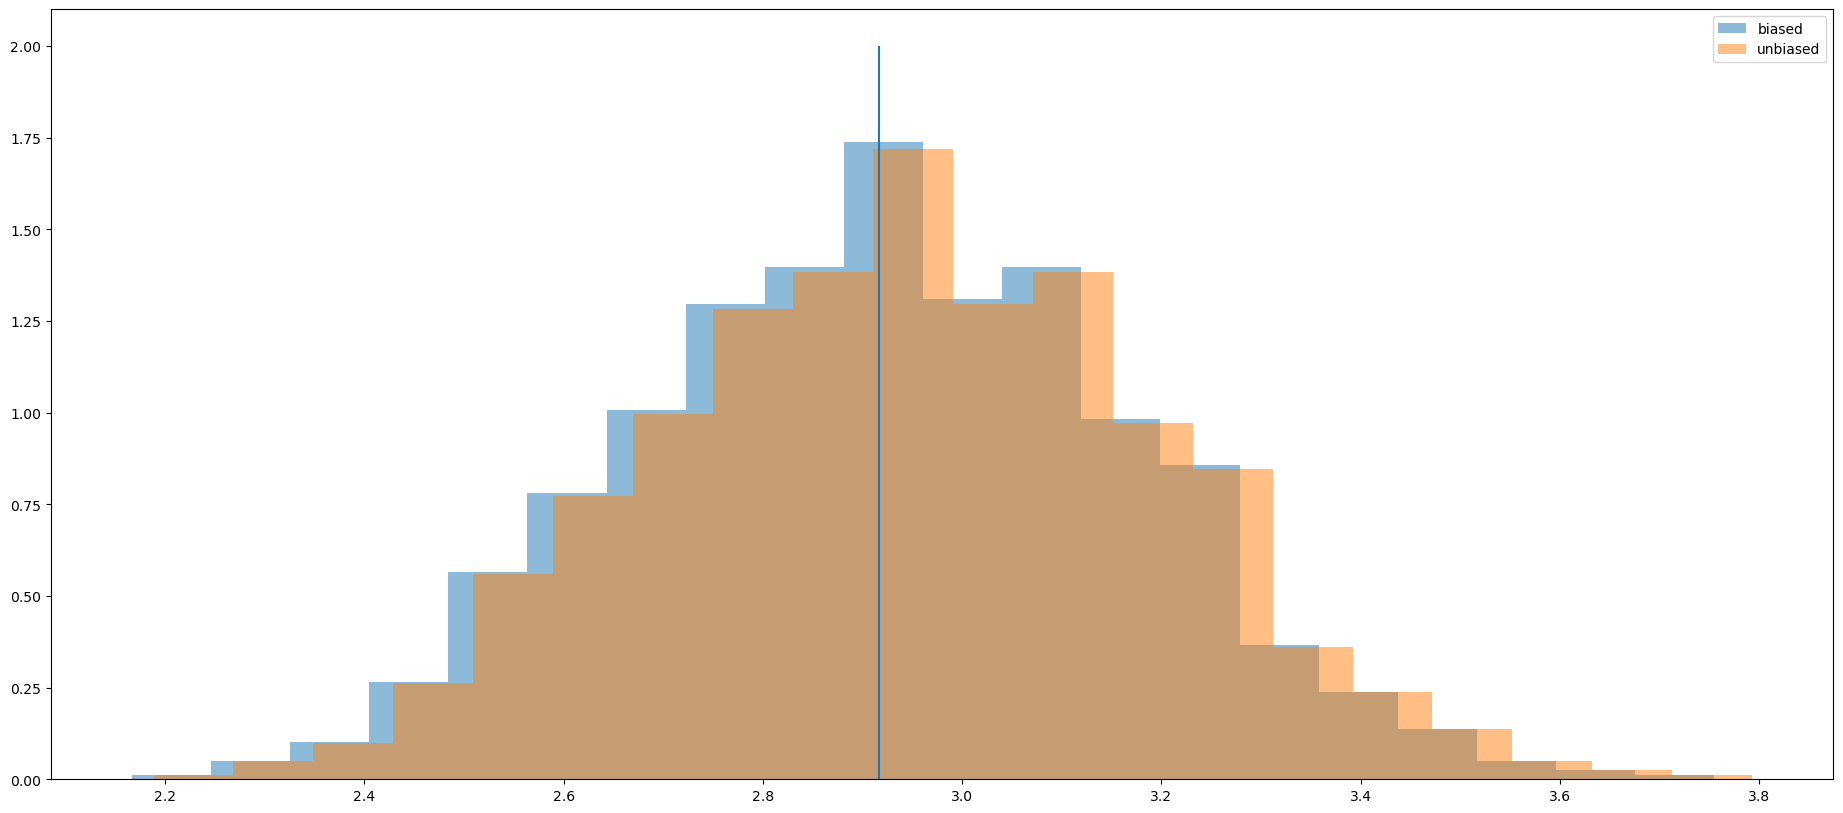

In [11]:
biased, unbiased = compare_bias()

plt.figure(figsize=(23, 10))
plt.hist(biased, 20, density=True, alpha=0.5, label='biased')
plt.hist(unbiased, 20, density=True, alpha=0.5, label='unbiased');
plt.legend()
plt.vlines(35/12, 0, 2); # population value

Maximum A Posteriori (MAP) estimator is an estimator that maximizes the posterior probability $p(\lambda|x)$ for an estimate of $\lambda$ given a _fixed_ $x$ value.

q.v. Bayes Theorem for Bayesians

$$p_{\lambda}(x) = \frac{p(x|\lambda)p(\lambda)}{p(x)}$$

MAP estimator is mode of the posterior distribution $p(\lambda|x)$.

## Independence, correlation and covariance
Random variables are independent if for all $x, y$
$$ P(X=x\textrm{ and }Y=y) = P(X=x)P(Y=y).$$
For continuous variables, have similar definition
$$ p(x,y) = p(x)p(y)$$

Let $\mathbb{E}(X)=\mu_X$, $\mathbb{E}(Y)=\mu_Y$, **covariance** is
$$\textrm{cov}(X,Y) = \mathbb{E}((X-\mu_X)(Y-\mu_y)) = \mathbb{E}(XY)-\mu_X\mu_Y$$
$$0\leq\textrm{cov}(X,Y)^2\leq\sigma_X^2\sigma_Y^2$$

**correlation** is
$$ \textrm{cor}(X,Y) = \frac{\textrm{cov}(X,Y)}{\sigma_X\sigma_Y} $$
Hence
$$ -1 \leq \textrm{cor}(X,Y) \leq 1 $$

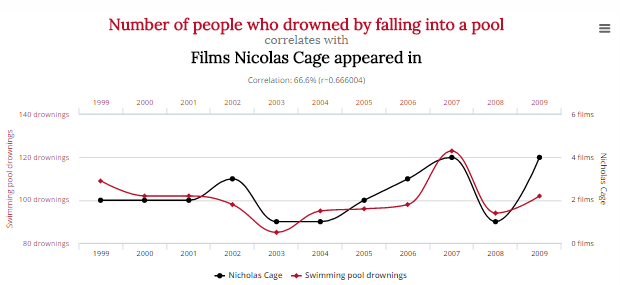
_from https://www.tylervigen.com/spurious-correlations_

## Part II Random numbers: integers on a computer

Two (maybe 3?) kinds of "randoms" generated by computers

 1. Pseudo-random/deterministic (PRNGs)
 2. Hardware/True random (TRNGs)
 3. Cryprographically secure pseudo-random (CSPRNG)
 
 

#### PRNGS

- Each "random" number in sequence derived by a rule from previous one(s).
- Hard to guess individually, but not "surprising"
- "Cheap" to generate
- Reproducable (given seed)
- given enough values, can predict the next

In [12]:
class Randu:
    """A (bad) example PRNG via linear congruences.
    Never EVER use this for anything non-trivial!"""
    
    def __init__(self, seed=1):
        
        self._I = seed
        
    def __call__(self):
        self._I = (65539*self._I)%(2**31)
        return self._I
 
randu = Randu(1)
print([randu() for _ in range(5)])
randu = Randu(2)
print([randu() for _ in range(5)])

[65539, 393225, 1769499, 7077969, 26542323]
[131078, 786450, 3538998, 14155938, 53084646]


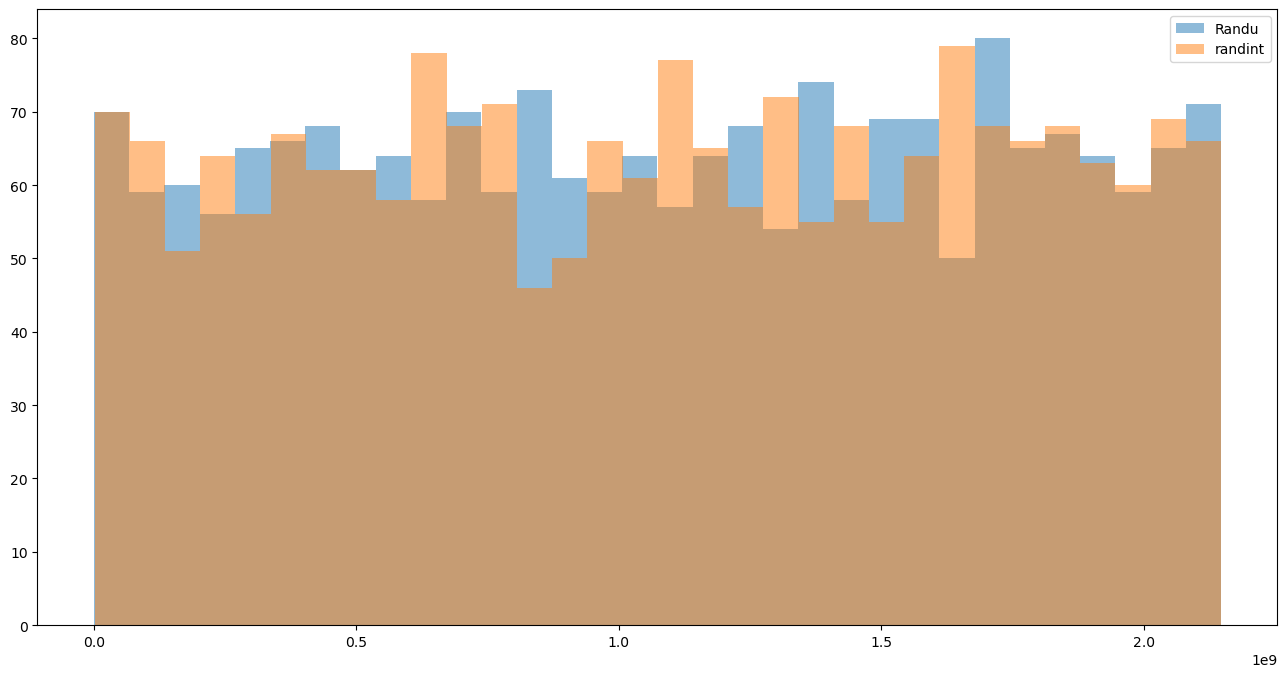

In [13]:
randu_data = [randu() for _ in range(2**11)]
# Python randint uses https://en.wikipedia.org/wiki/Mersenne_Twister
random_data = [random.randint(0,2**31-1) for _ in range(2**11)]
plt.figure(figsize=(16, 8))
plt.hist(randu_data, 32, alpha=0.5, label='Randu')
plt.hist(random_data, 32, alpha=0.5, label='randint')
plt.legend();

Similar to code used in Windows C/C++ rand implementation

In [14]:
class msvc_rand():
    def __init__(self, seed=1):
        
        self._I = seed
        
    def __call__(self):
        self._I = self._I*214013 + 2531011
        return (self._I) >> 16 & 0x7fff 
    
rand = msvc_rand(1995)

[rand() for _ in range(10)]

 

[6553, 20518, 8676, 3628, 8127, 14071, 24553, 25076, 19233, 20449]

- Both examples of "linear congruential generators" (LCGs).
- These are fast methods.
- Come with some problems (in statistical tests).
- `randu` is **BAD**. Windows Visual studio `rand` is "not good". Linux/mac `rand` could meet current acceptable standards (default one mostly does right now)
- Python uses "Mersenne twister" (non-LCG) similar to default linux `rand`.
- For C++, worth looking at the `<random>` library which has lots of well defined methods.
    

### Good rules of thumb
- Explicit choice of a RNG is better than an a black box one.
- Know (and state) what PRNG you are using (e.g. look in `<random>` library in C++).
- Keep a copy of the seed, aim to seed once per problem.
- Don't use a fixed seed where randomness is heavily important.
- All of this gets a lot weirder in parallel.

#### TRNGs

- Use external physical/hardware source of randomness (often as seed of PRNG)
- Can't be guessed based on previous data
- High cost to implement
- Not reproducable
- Useful for cryptography/security

#### CSPRNGs

- Use TRNG to periodically (re)seed goood PRNG on initialization
- Unlikely to be guessed based on previous data
- Middling cost to implement
- Not reproducable
- Still good for cryptography/security

In [15]:
### An example interaction with a CSPRNG
import os
b = os.urandom(4)
print(b)
# Here "big" means https://en.wikipedia.org/wiki/Endianness#Big-endian
int.from_bytes(b, 'big')

b'\xd3\xcb\x15>'


3553301822

## Random reals on a computer

- The heart of an RNG is almost always a generator for uniform integers
- Usually also between 0 and some $N_\textrm{max}$ (often in form $2^N$).
- To get other distributions need to do extra mathematics

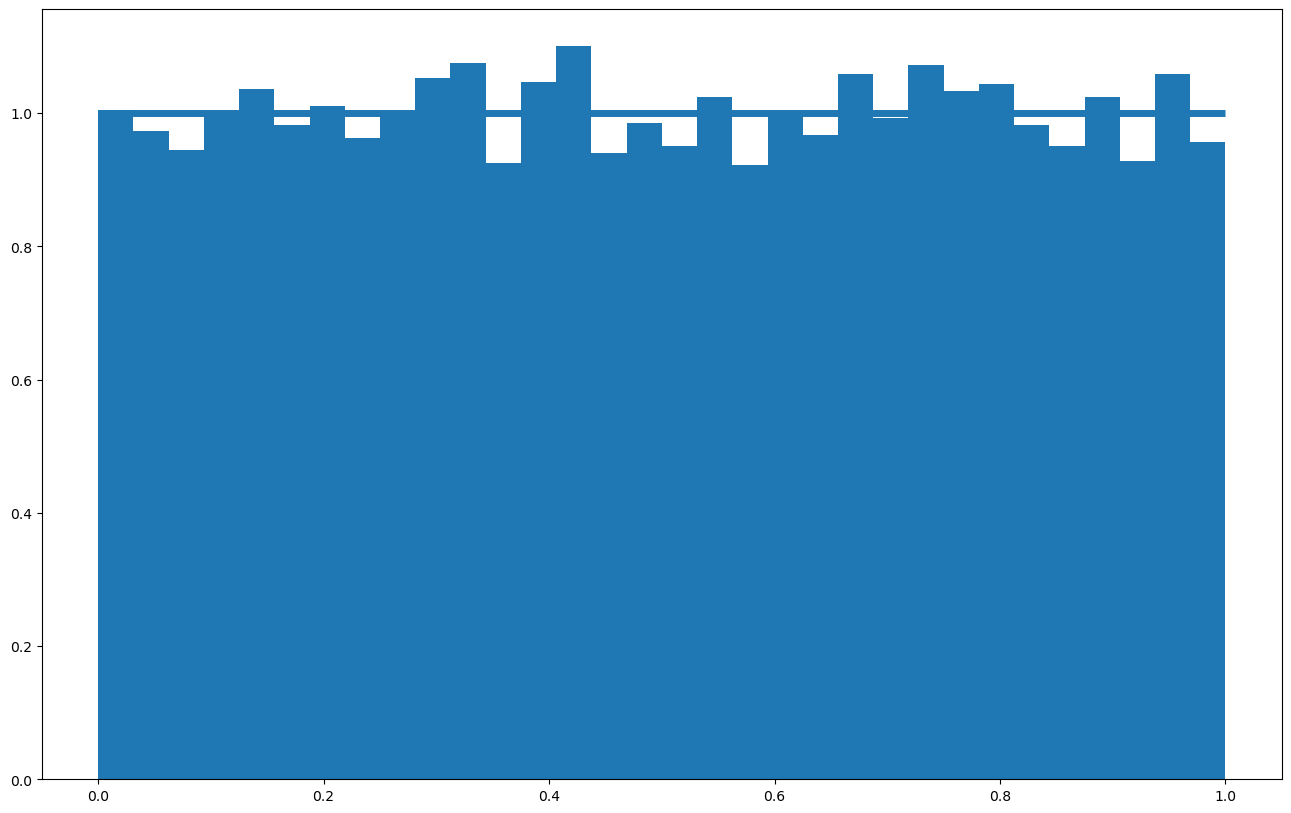

In [16]:
class RealRandu(Randu):
    """Real uniform random number generator based on RANDU.
    This approach is again common in toy code, but flawed
    in several ways (generating great random reals is hard).
    """
    def __call__(self):
        super().__call__();
        return self._I/(2**31)
    
randr = RealRandu()
data = [randr() for _ in range(9999)]
plt.figure(figsize=(16,10))
plt.hlines(1,0,1, lw=5)
plt.hist(data, 32, density=True);

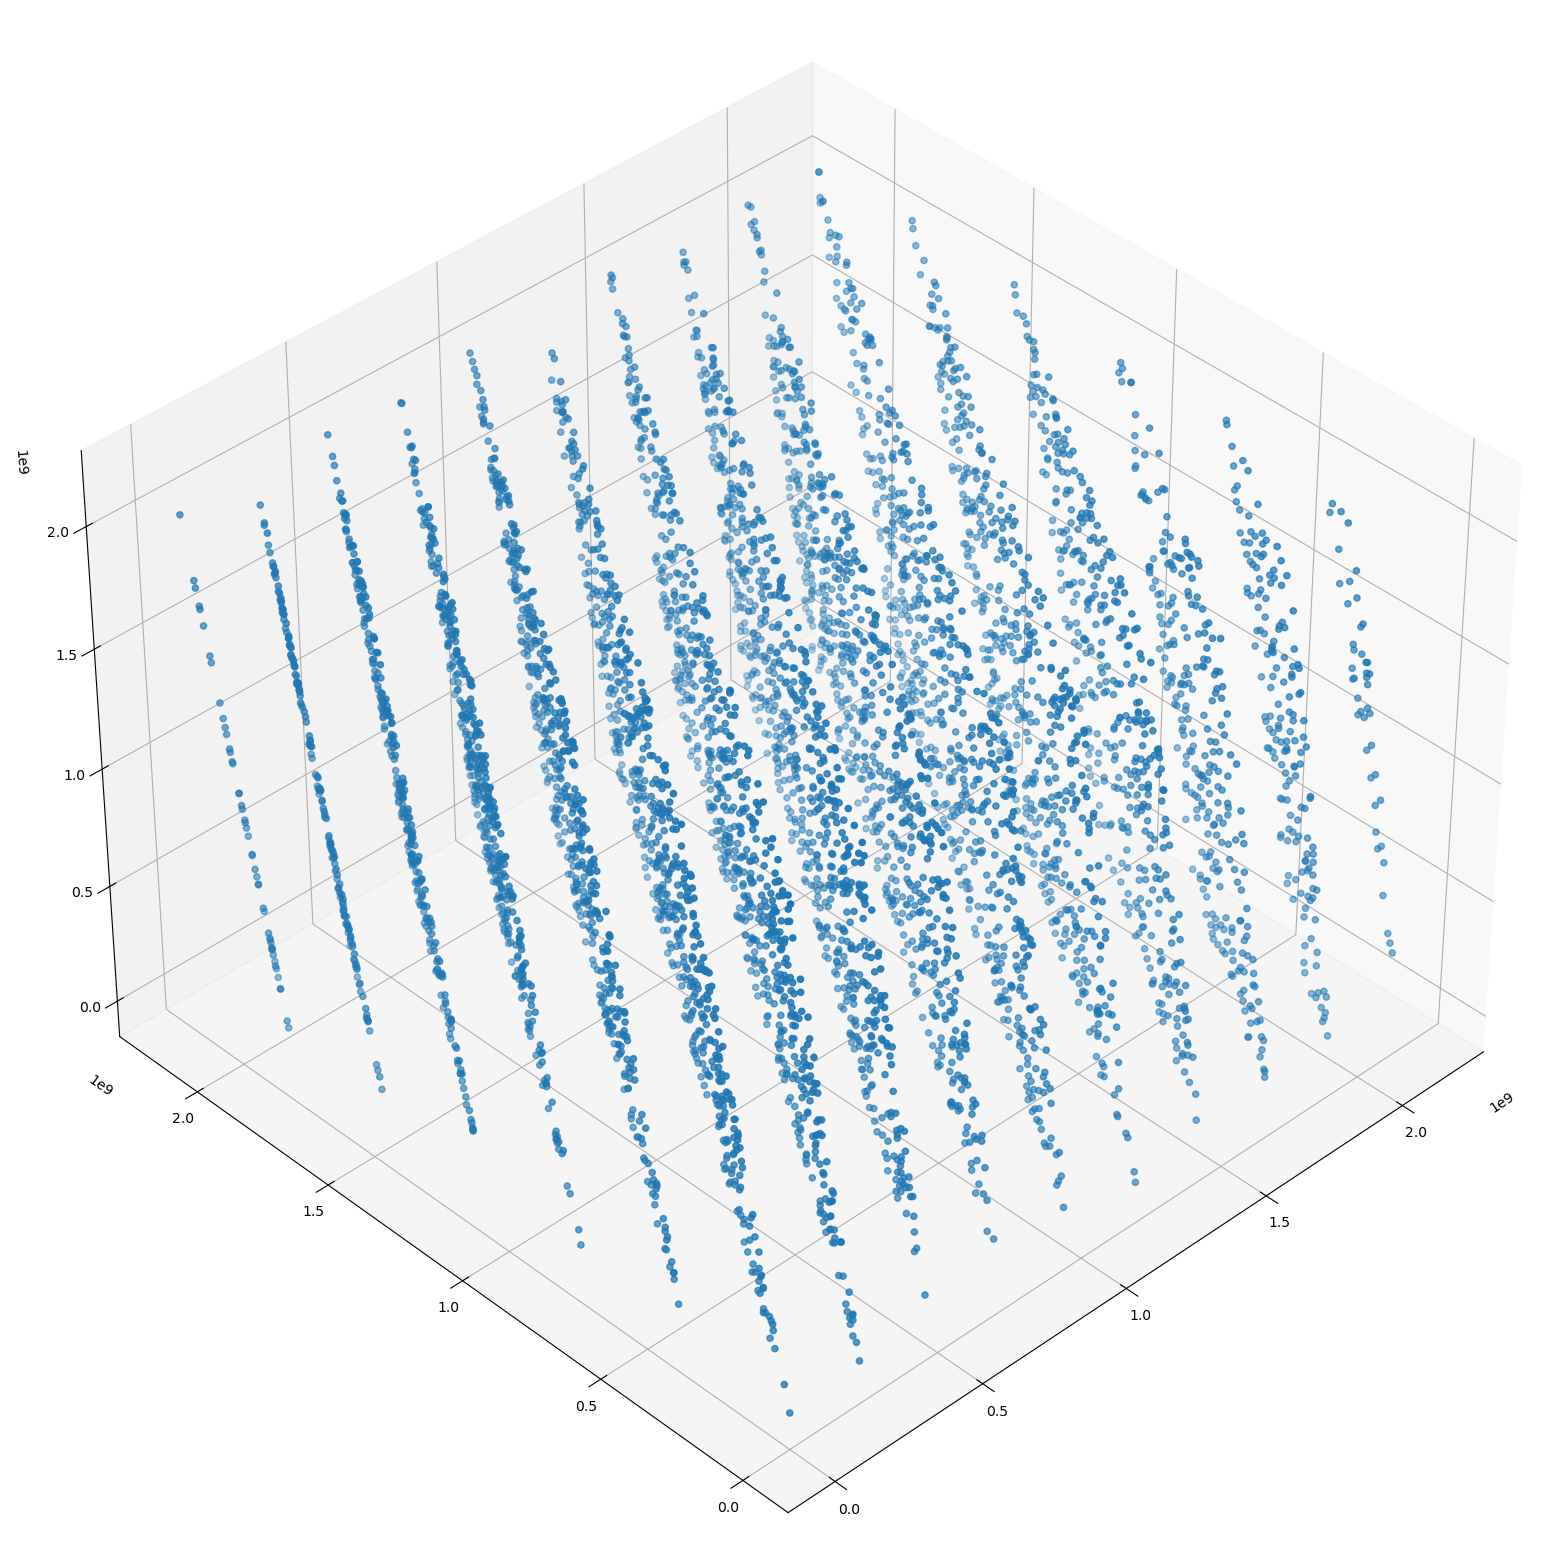

In [17]:
### Now for the true evil of Randu!
from mpl_toolkits.mplot3d import Axes3D
rand = Randu(1)
data = [rand() for _ in range(18000)]
data = np.array(data).reshape((len(data)//3, 3)).T
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data)

ax.azim = -134; ax.elev =38

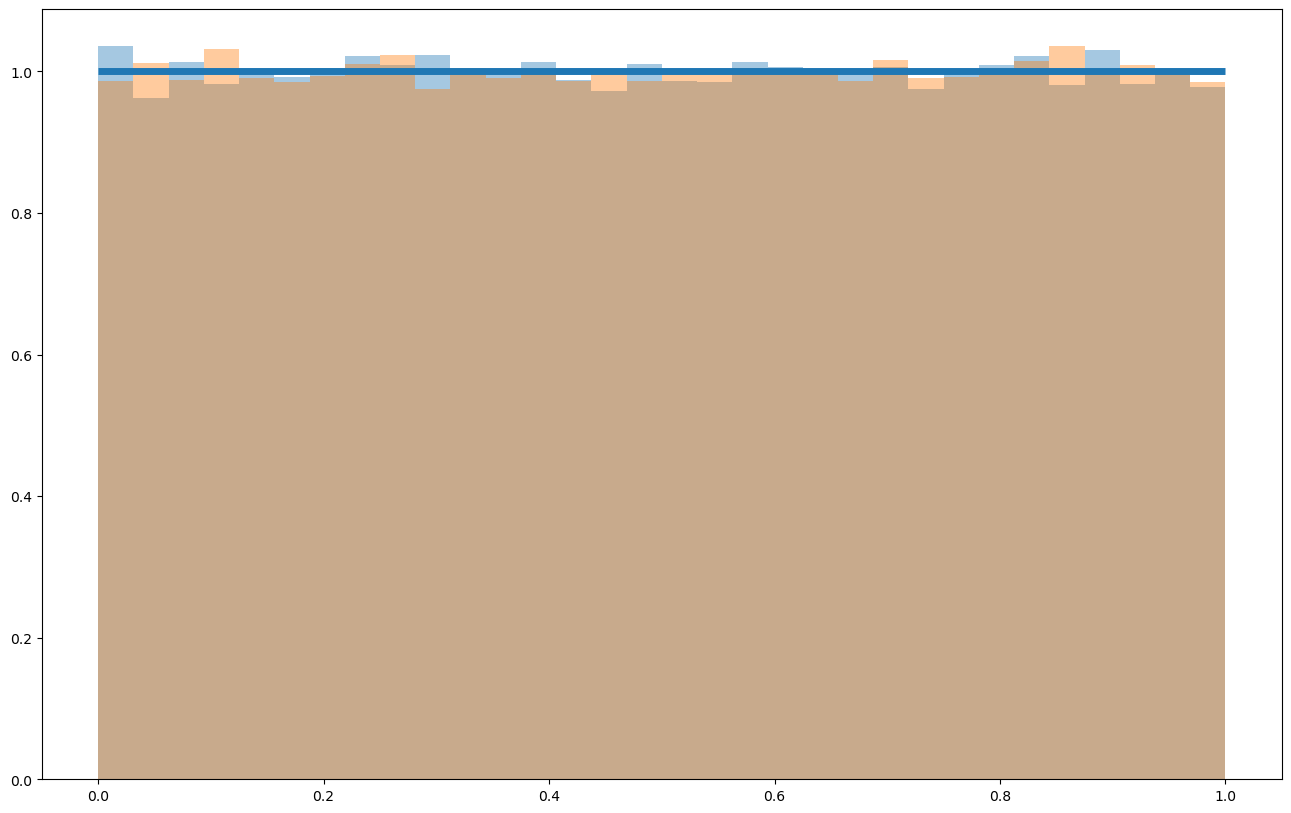

In [18]:
# What about making Gaussians?
# We can start from uniforms

N = 100000
a = np.random.uniform(size=N)
b = np.random.uniform(size=N)

plt.figure(figsize=(16,10))
plt.hist(a, 32,density=True, alpha=0.4)
plt.hist(b, 32, density=True, alpha=0.4)
plt.hlines(1.0, 0.0, 1.0, lw=5);

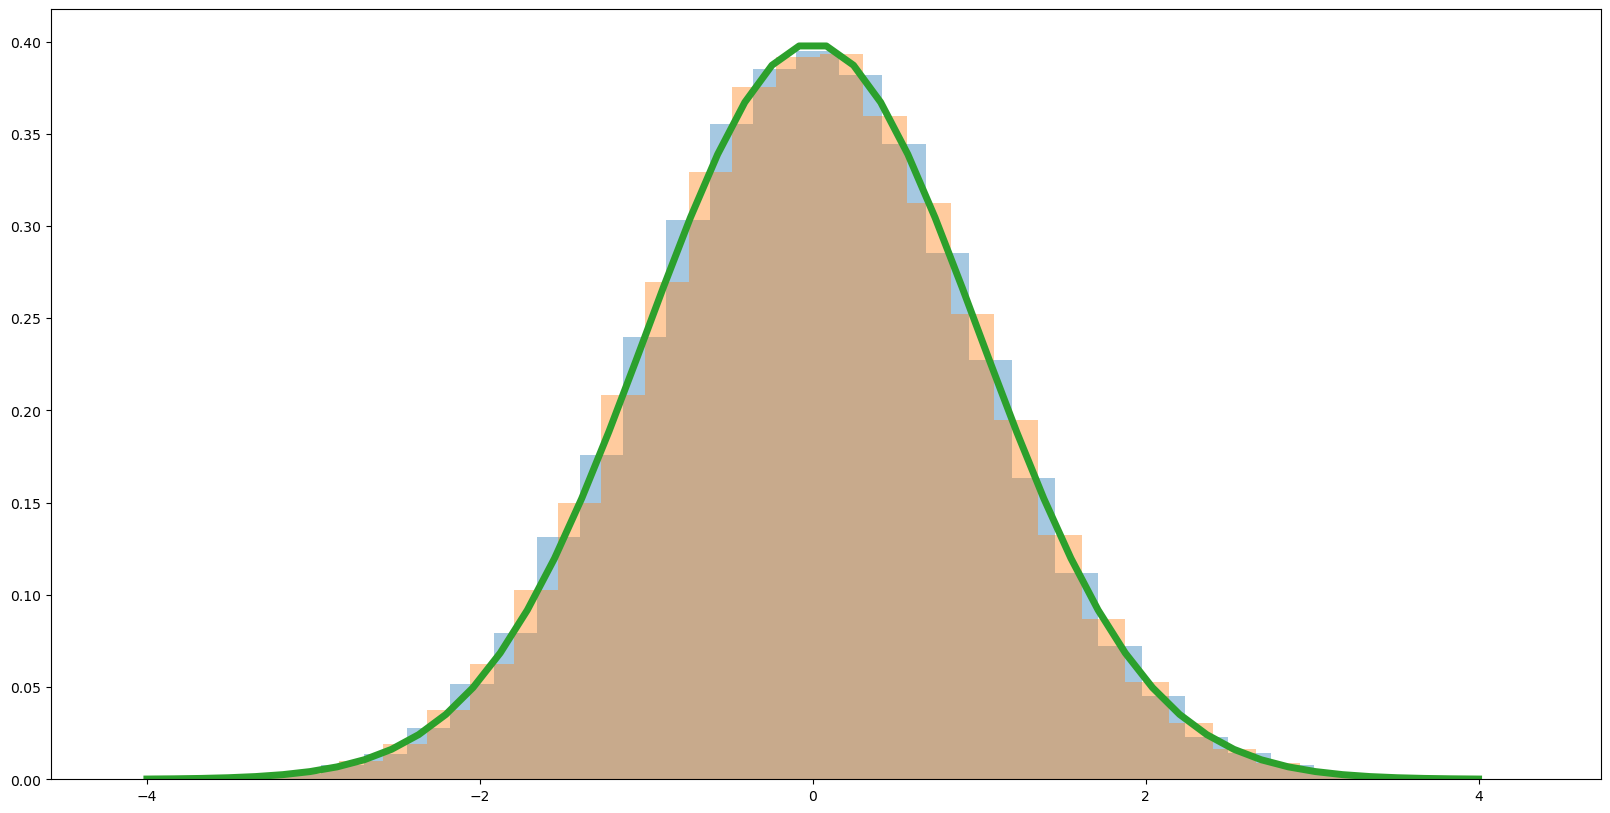

In [19]:
#A python demonstration of the Box-Muller algorithm

def box_muller(a, b):
    r = np.sqrt(-2*np.log(a))
    theta = 2*np.pi*b
    return r*np.sin(theta), r*np.cos(theta)
n1, n2 = box_muller(a, b)
plt.figure(figsize=(20, 10))
plt.hist(n1, 32, density=True, alpha=0.4)
plt.hist(n2, 32, density=True, alpha=0.4)
x = np.linspace(-4, 4)
def p_x(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x, p_x(x), lw=5);

## On to full Data Assimilation: a good (if now somewhat dated) reference

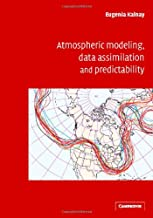

Eugenia Kalnay - Atmospheric modeling, data assimilation and predicability

## The Language of data assimilation

A paper (Ide et al. 1997) sets out *one* standard notation:

$$ \mathbf{x} : \textrm {vector of state variables (Stephan's $u$)} $$
$$ \mathbf{y} : \textrm{vector of  observations (data)}$$

#### States
$$ \mathbf{x}_b : \textrm {Background state (first guess)}$$
$$ \mathbf{x}_a : \textrm {Analysis state (final guess)}$$
$$ \mathbf{x}_t : \textrm {True state}$$
#### Observations & models
$$ \mathbf{H}, \mathbf{h}: \textrm{observation operator (tell me $\mathbf{y}$ given $\mathbf{x}$)} $$
$$ \mathbf{M}, \mathbf{m}: \textrm{forward model (not quite Stephan's $g$)}$$

#### Errors
$$ \mathbf{e}_b:= \mathbf{x}_b-\mathbf{x}_t : \textrm {Background error}$$
$$ \mathbf{e}_a:= \mathbf{x}_a-\mathbf{x}_t : \textrm {Analysis error}$$
$$ \mathbf{e}_o:= \mathbf{y}-\mathbf{h}(\mathbf{x}_t) : \textrm {Observation error}$$

#### Error covariance matrixes

$$ \mathbf{B}:=\mathbb{E}(\mathbf{e}_b\mathbf{e}_b^T): \textrm{Background}$$
$$ \mathbf{P}:=\mathbb{E}(\mathbf{e}_a\mathbf{e}_a^T): \textrm{Analysis}$$
$$ \mathbf{R}:=\mathbb{E}(\mathbf{e}_o\mathbf{e}_o^T):\textrm{Observations}$$

## Nudging: the first DA method

Numerics normally updates $\mathbf{x}$ through discretized differential/difference equation
$$\frac{\partial \mathbf{x}}{\partial t} = \mathbf{m}(\mathbf{x}; \nu)$$

q.v first part of Stephan's $g$.

#### State estimation versus parameter estimation

- Most data assimilation draws distinction between model **state**, which changes with time and model _parameters_, which are assumed fixed for each run.
- A state estimate is needed  :
   1. to know where we are/were
   2. as ICs to run model forward

#### Nudging

Given direct observation, $\mathbf{y}$ update model state $\mathbf{x}$ via fictional force

$$\frac{\partial \mathbf{x}}{\partial t} = \mathbf{m}(\mathbf{x};\nu)\color{red}{+\frac{\alpha}{\Delta t}(\mathbf{y}-\mathbf{x})}$$

*not* a brilliant method:
 - only works with direct observations of model variables
 - fake heating drives spurious circulations
 - point updates only.
 
 Lets get statistical!

## Statistical interpolation
#### The time from two clocks

- Suppose you have two clocks
 * First says it's 10:21 and 95% of the time it's correct $\pm 2$ minutes
 * Second says it's 10:24 and 95% of the time it's correct $\pm 1$ minute
- What do you think the time is?

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity
- Unbiased : Analysis error has zero mean (when averaged over error distribution via $\mathbb{E}$)

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity
- Unbiased : Analysis error has zero mean (when averaged over error distribution via $\mathbb{E}$)
- Linear: $T_\textrm{guess} = a T_1 + b T_2$

## The BLUE

For quantative version, can seek Best Linear Unbiased Estimator

- Estimator : fixed guess at statistical quantity
- Unbiased : Analysis error has zero mean (when averaged over error distribution via $\mathbb{E}$)
- Linear: $T_\textrm{guess} = a T_1 + b T_2$
- Best: minimise expected __mean square error__, $\mathbb{E}(e_1^2 +e_2^2)$

$$ T_1 = T_t+e_1 $$
$$ T_2 = T_t+e_2 $$
$$ T_\textrm{guess} = (a+b) T_t + a e_1 +b e_2 $$
$$ e_\textrm{guess} := T_\textrm{guess}-T_t = (a+b-1)T_t + ae_1+be_2 $$

$$ \mathbb{E}(e_\textrm{guess}) := (a+b-1)T_t + a\mathbb{E}(e_1)+b\mathbb{E}(e_2) $$
- Providing $e_1$ & $e_2$ are unbiased want
$$ a+b = 1$$
 for estimate to be unbiased - constraint.
- If observations are also independent
$$\mathbb{E}(e^2_\textrm{guess}) = a^2\mathbb{E}(e_1^2) +b^2 \mathbb{E}(e_2^2)$$

- Substitute for $b$ and variances:
$$\mathbb{E}(e^2_\textrm{guess}) = a^2\sigma_1^2 +(1-a)^2 \sigma_2^2$$
- Minimise w.r.t $a$
$$\frac{df}{da}= 2a\sigma_1^2 -2(1-a)\sigma_2^2 =0$$
- i.e.
$$ a = \frac{\sigma_2^2}{\sigma_1^2 +\sigma_2^2} $$
$$ T_\textrm{BLUE} = \frac{\sigma^2_2 T_1+\sigma_1^2 T_2}{\sigma^2_1+\sigma^2_2} $$

BLUE analysis state is variance weighted average.

In [20]:
# We'll make the truth the zero state 
T_true = 0.0

N = 1000
variance_1 = 2.0
variance_2 = 1.0
T_1 = T_true + np.random.normal(0, scale=variance_1, size=N) # Gaussian noise
T_2 = T_true + np.random.uniform(-np.sqrt(3*variance_2),
                                 np.sqrt(3*variance_2), size=N) # Uniform noise
def T_guess(a):
    """Function to generate zero bias estimator"""
    return a*T_1+(1-a)*T_2
x=np.linspace(0, 1)
e_guess = [np.mean((T_guess(_)-T_true)**2) for _ in x]

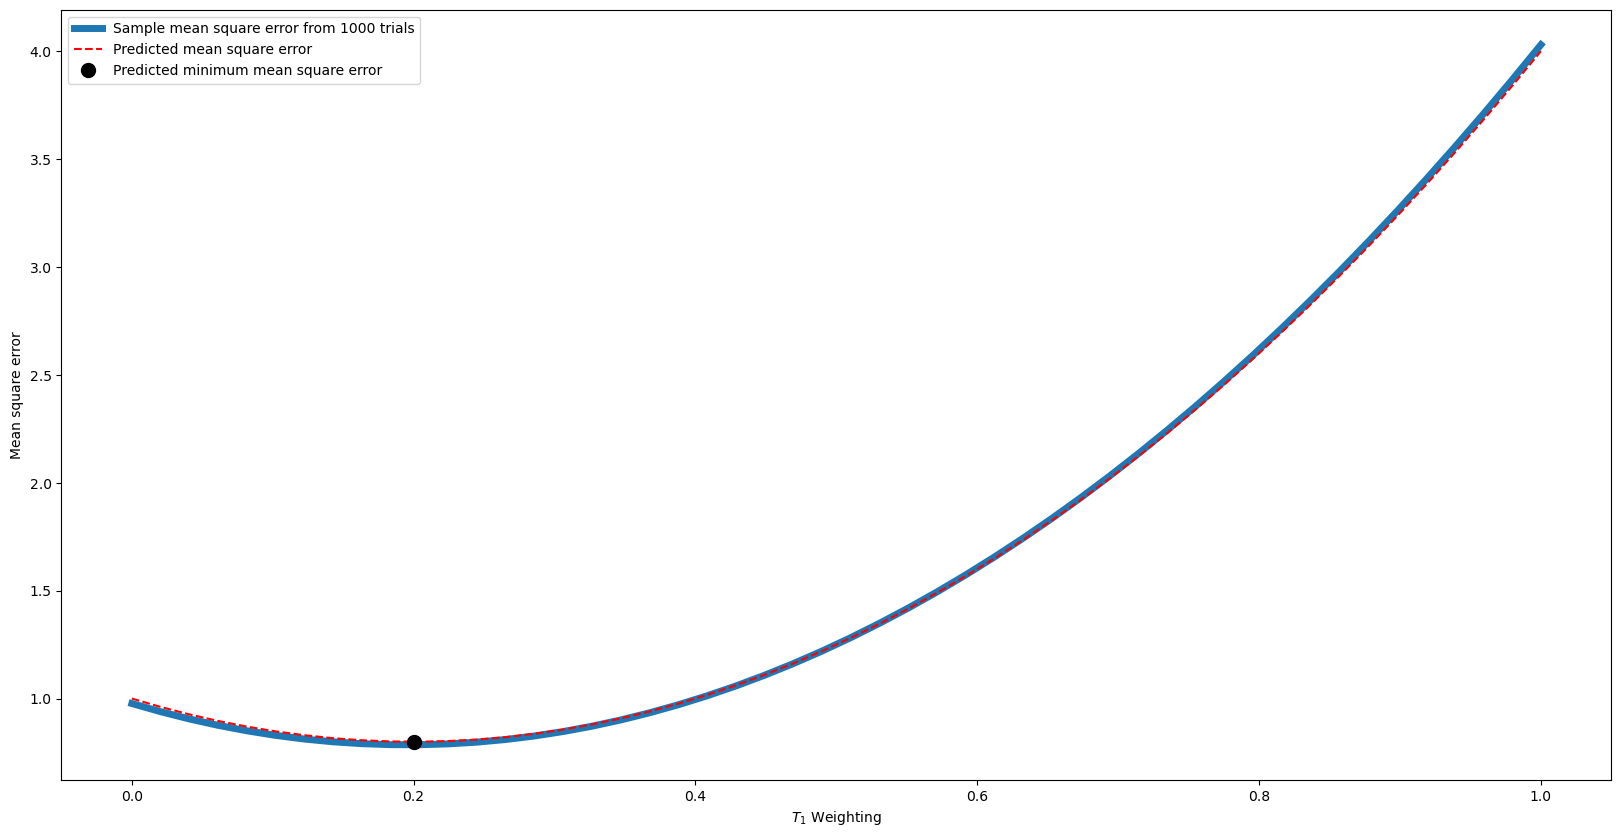

In [21]:
plt.figure(figsize=(20,10))
plt.plot(x, e_guess, lw=5, label=f'Sample mean square error from {N} trials')
plt.plot(x, variance_1**2*x**2+variance_2**2*(1-x)**2, 'r--', label='Predicted mean square error')
plt.plot(variance_2**2/(variance_1**2+variance_2**2), (variance_1**2*variance_2**2)/(variance_1**2+variance_2**2),'ko', ms=10, label='Predicted minimum mean square error');
plt.xlabel(r'$T_1$ Weighting'); plt.ylabel('Mean square error'); plt.legend();

### Optimal Interpolation
Now let's write down a vectorized version for a linear observation operator!

New information (aka *innovation* vector) is $\mathbf{y}-\mathbf{H}\mathbf{x}_b$. I.e. _observed difference_ from model prediction.

Want a new state by linear combination $\mathbf{x}_a=\mathbf{x}_b+\mathbf{W}(\mathbf{y}-\mathbf{H}\mathbf{x}_b)$

Choose to minimise total analysis mean square error
$$\tag{mean square error} \mathcal{J} = \mathbb{E}(\mathbf{e}_a\cdot\mathbf{e}_a)$$

$$\tag{observation error}\mathbf{e}_o := \mathbf{y} -\mathbf{H}\mathbf{x}_t$$
$$ \mathbf{x}_a-\mathbf{x}_t = \mathbf{x}_b-\mathbf{x}_t +\mathbf{W}(\mathbf{H}\mathbf{x}_t+\mathbf{e}_o-\mathbf{H}\mathbf{x}_b)$$
So
$$ \mathbf{e}_a = \mathbf{e}_b +\mathbf{W}(\mathbf{e}_o-\underbrace{\mathbf{H}\mathbf{e}_b}_{=\mathbf{H}\mathbf{x}_b -\mathbf{H}\mathbf{x}_t})$$
Get "normal" equation $\frac{\partial\mathcal{J}}{\partial\mathbf{W}}$
$$\mathbb{E}\left(\left[\mathbf{e}_b +\mathbf{W}(\mathbf{e}_o-\mathbf{H}\mathbf{e}_b)\right](\mathbf{e}_o-\mathbf{H}\mathbf{e}_b)^T\right)=\mathbf{
0}.$$
Assume errors are unbiased and no correlations between $\mathbf{e}_b$ and $\mathbf{e}_o$.
$$-\mathbb{E}(\mathbf{e}_b\mathbf{e}_b^T)\mathbf{H}^T+\mathbf{W}\left(\mathbb{E}(\mathbf{e}_o\mathbf{e}_o^T)+\mathbf{H}\mathbb{E}(\mathbf{e}_b\mathbf{e}_b^T)\mathbf{H}^T\right)=\mathbf{0}$$

$$-\mathbf{B}\mathbf{H}^T+\mathbf{W}\left(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T\right)=\mathbf{0}$$
- Optimal (Kalman) gain
$$\mathbf{W}=\mathbf{B}\mathbf{H}^T\left(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1}$$
- Hence optimal analysis state is
$$\mathbf{x}_a=\mathbf{x}_b+\mathbf{B}\mathbf{H}^T\left(\mathbf{R}+\mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1}(\mathbf{y}-\mathbf{H}\mathbf{x}_b)$$

In [22]:
### Example optimal interpolation implementation & solution
from scipy.linalg import inv
### define the standard deviation of the background and observations

sigma_t = 1.0; sigma_b = 1.0; sigma_r = 1.0
l_t = 0.2; l_e = 0.1; l_b = l_e
s = np.linspace(0, np.pi)

e_b = np.zeros(len(s));  x_t = np.zeros(len(s))
for _ in range(len(s)):
    e_b += np.random.normal(0, sigma_b)*np.exp(-(s-s[_])**2/l_e**2)
    x_t += np.random.normal(0, sigma_t)*np.exp(-(s-s[_])**2/l_t**2)
x_b = x_t + e_b

In [23]:
H = np.zeros((len(s)//5, len(s)))
for _ in range(H.shape[0]):
    H[_,5*_] = 1
    
y = np.dot(H, x_t) 
y += np.random.normal(0, 1, size=(y.shape))
R = sigma_r**2*np.eye(y.shape[0])

s2 = np.broadcast_to(s, (len(s), len(s)))
## Here we calculate B from known statistics 
B = sigma_b**2*np.exp(-(s2-s2.T)**2/l_b**2)

W = B.dot((H.T)).dot(inv(R+H.dot(B.dot(H.T))))
x_a = x_b + W.dot(y-H.dot(x_b))

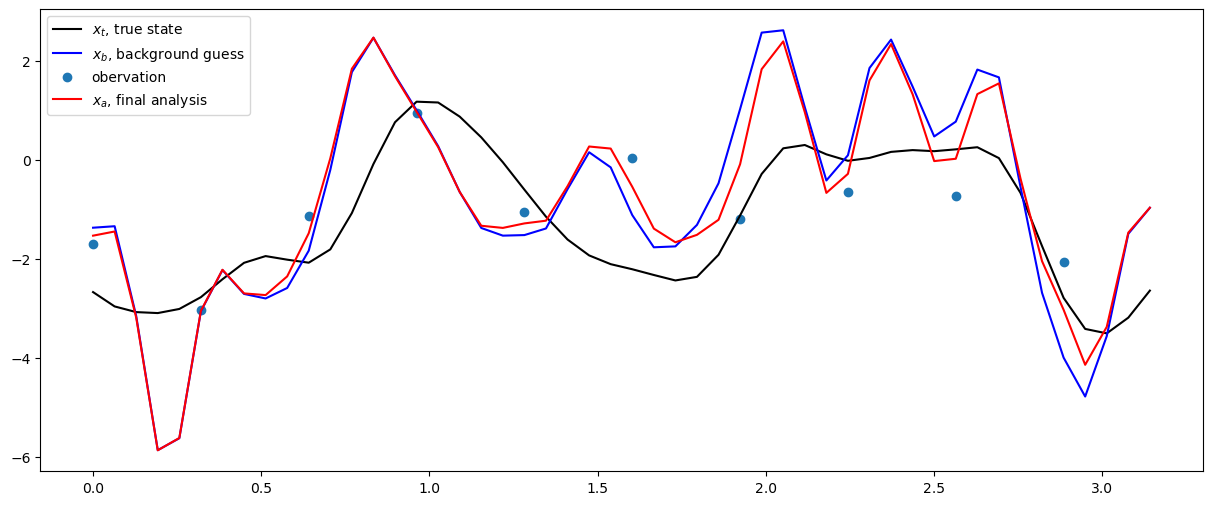

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(s, x_t, 'k', label='$x_t$, true state')
plt.plot(s, x_b, 'b', label='$x_b$, background guess')
plt.scatter(s[::5], y, label='obervation')
plt.plot(s, x_a, 'r', label='$x_a$, final analysis')
plt.legend();

#### A note on $\mathbf{H}$

- Observation operator _projects_ state onto the observations
- Says what we expect to see.
- An example is often (linear) interpolation.
- Eg. if $y_1$ is direct observation halfway between 1st and 2nd gridpoint,
$$ H_{1i} = (0.5,0.5,0,\ldots,0)$$

#### Good things with Optimal Interpolation:
- Can use a single choice of matrix $\mathbf{B}$ (hard to find)
- If $\mathbf{x}$ is much longer than $\mathbf{y}$, matrix to invert is probably (relatively) small.
#### Bad things:
- No time dependence (wasting information)
- Linear $\mathbf{H}$ operators only. Can do better with a few more assumptions.

## Spatial Variational Assimilation: 3D-Var

- *Assume* all errors are multivariate Gaussian distributed.
- *Assume* observation and state errors are independent.
- Look for maximum _a posteriori_ PDF of true state (i.e centre of the bell curve) given observations & previous guess (_a priori_ likelihood).
- Bayes' Theorem plus independece:

$$ \mathcal{L}_{\textrm{posterior}}(\mathbf{x}) = p(\mathbf{x}\vert\mathbf{x}_b,\mathbf{y}) = \frac{p(\mathbf{y}\vert \mathbf{x})p(\mathbf{x}|\mathbf{x}_b)}{P(\mathbf{y})} $$

$$\mathcal{L}(\mathbf{x}\vert\mathbf{y}, \mathbf{x}_b) \propto \exp\left(-\frac{(\mathbf{y}-\mathbf{h}(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x})+(\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}))}{2}\right) $$

Here $$P(\mathbf{y}) = \int_{\mathbf{X}} p(\mathbf{y}\vert\mathbf{x})p(\mathbf{x}|\mathbf{x}_b) d\mathbf{x}$$ is a constant normalization factor.

Sufficient to *minimize*
$$J(\mathbf{x}) = \frac{1}{2}\left[(\mathbf{y}-\mathbf{h}(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x}))+(\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b+\mathbf{x})\right]$$
- "_a posteriori log-likelihood_"
- Minimum at $\mathbf{x}=\mathbf{x}_a$ (analysis state).

Example 3D-Var implementation and solution
- We will use some weather-like 2d data (results from a quasi-geostrophic ("QG") model)
- We'll generate our B from the "climatology"

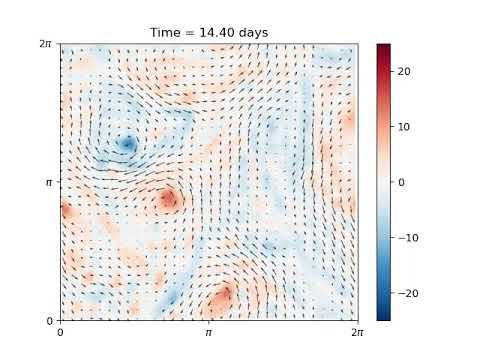

In [25]:
from IPython import display
display.YouTubeVideo('UXqsmouzfJQ', loop=1, playlist='UXqsmouzfJQ')

In [26]:
U = np.load('data/U_data.npz')['U'][::2, ::2, :] # we're subsampling for code speed here 
V = np.load('data/V_data.npz')['V'][::2, ::2, :]
X, Y = np.meshgrid(np.linspace(0,2*np.pi, U.shape[0]),
                   np.linspace(0,2*np.pi, U.shape[1]))

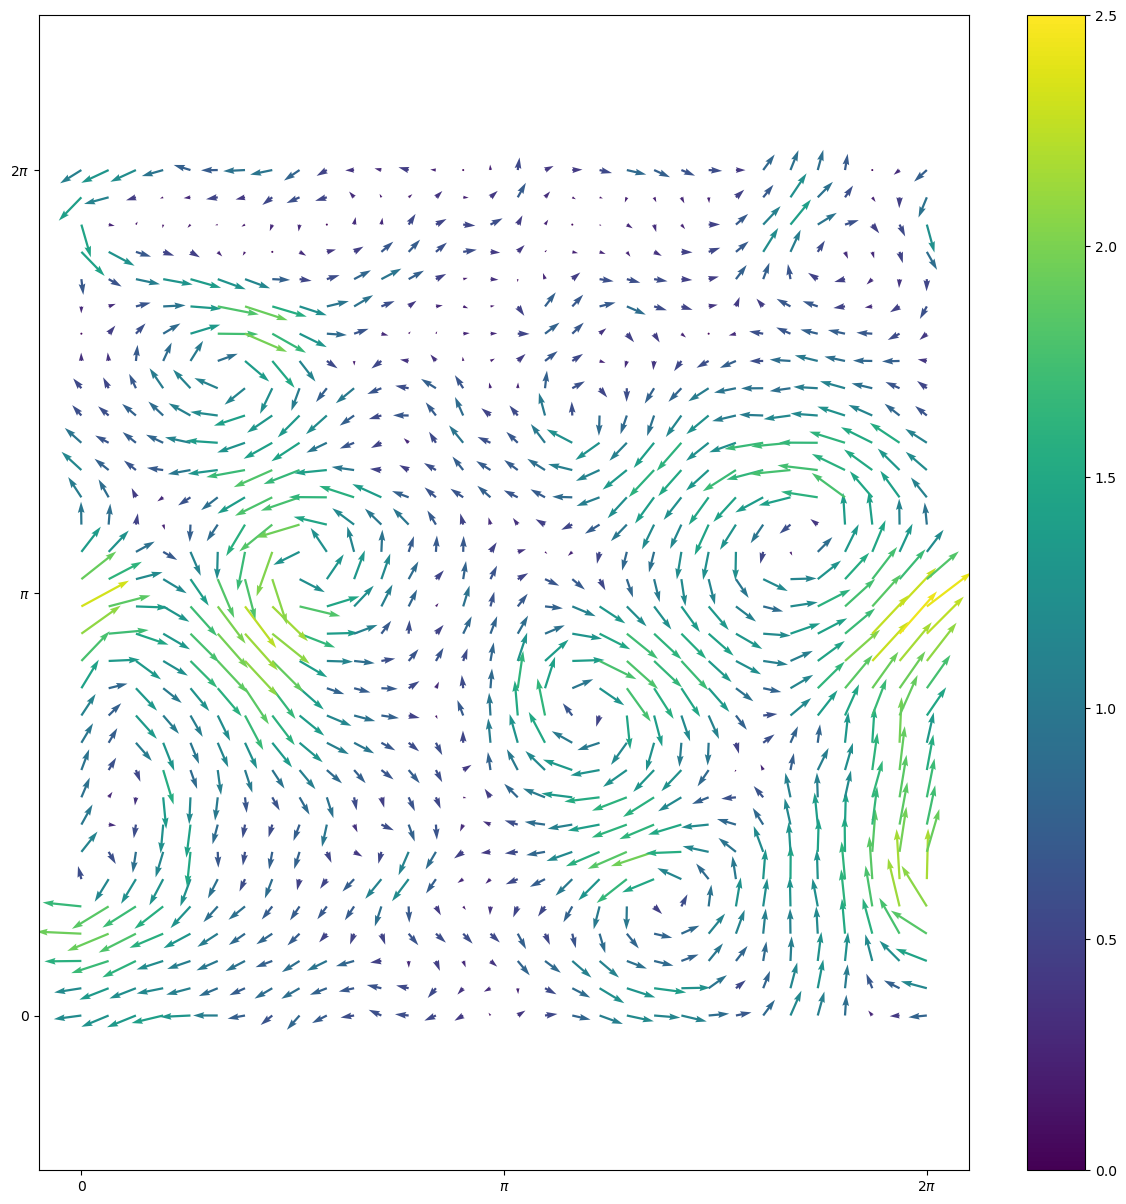

In [27]:
def plot_wind(X, Y, u, v):
    plt.figure(figsize=(15,15))
    plt.quiver(X, Y, u, v, np.sqrt(u**2+v**2),
               scale=4.0e1, clim=(0, 2.5))
    plt.colorbar()
    plt.axis('equal')
    plt.xticks([0,np.pi, 2*np.pi],[0,r'$\pi$',r'$2\pi$'])
    plt.yticks([0,np.pi, 2*np.pi],[0,r'$\pi$',r'$2\pi$'])

plot_wind(X, Y, U [:,:, 0], V[:,:,0]);

In [28]:
U_t, V_t = U[:,:,0], V[:, :, 0] # our true state
nx, ny= U_t.shape

# observation locations
n_full = (nx*ny)//32
n_speed = (ny*ny)//8
y_loc = np.random.randint(0, nx*ny, n_full+n_speed)
# observation values
y = np.empty(2*n_full+n_speed)
y[:n_full] = U_t.ravel()[y_loc[:n_full]] + np.random.normal(0, 0.1, n_full)
y[n_full:2*n_full] = V_t.ravel()[y_loc[:n_full]] + np.random.normal(0, 0.1, n_full)
y[2*n_full:] = (np.sqrt(U_t.ravel()[y_loc[n_full:]]**2
                      + V_t.ravel()[y_loc[n_full:]]**2)
                      + np.random.normal(0, 0.1, n_speed))

U_o = np.zeros((nx, ny)); V_o = np.zeros((nx, ny));
U_o.ravel()[y_loc[:n_full]]= U_t.ravel()[y_loc[:n_full]]
V_o.ravel()[y_loc[:n_full]]= V_t.ravel()[y_loc[:n_full]]

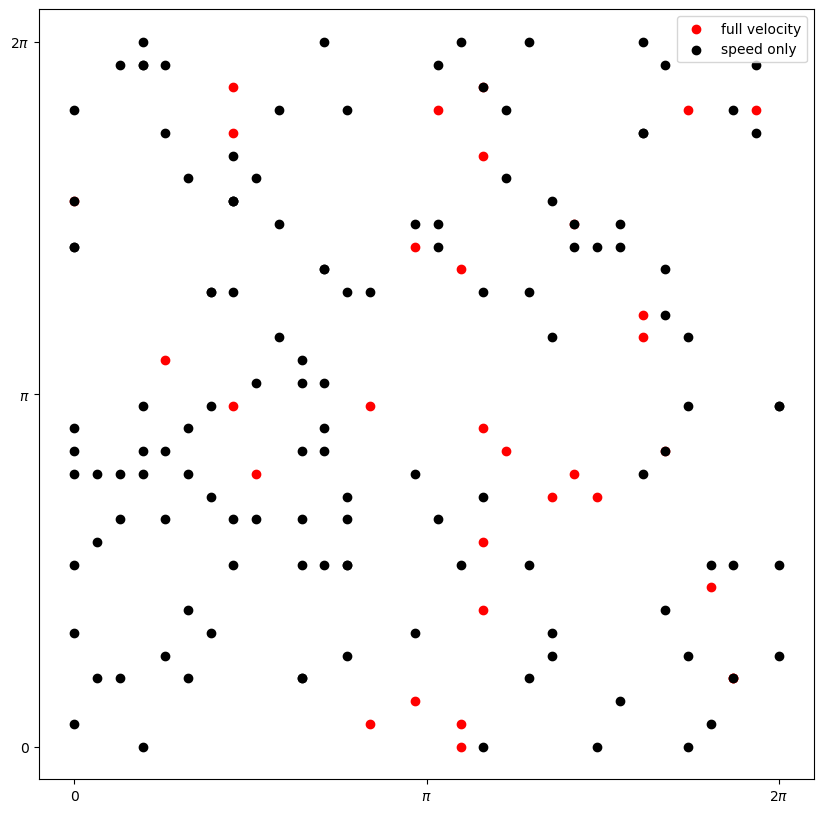

In [29]:
def h(x):
    hx = np.empty(2*n_full+n_speed)
    u = x[y_loc]
    v = x[ny*nx+y_loc]
    hx[:n_full] = u[:n_full]
    hx[n_full:2*n_full] = v[:n_full]
    hx[2*n_full:] = np.sqrt(u[n_full:]**2+v[n_full:]**2)
    
    return hx

R = 0.1**2*np.eye(2*n_full+n_speed)

plt.figure(figsize=(10,10))
plt.scatter(X.ravel()[y_loc[:n_full]], Y.ravel()[y_loc[:n_full]], c='r', label='full velocity')
plt.scatter(X.ravel()[y_loc[n_full:]], Y.ravel()[y_loc[n_full:]], c='k', label='speed only')
plt.xticks([0,np.pi, 2*np.pi],[0,r'$\pi$',r'$2\pi$'])
plt.yticks([0,np.pi, 2*np.pi],[0,r'$\pi$',r'$2\pi$'])
plt.axis('equal');
plt.legend()

(32, 32)


Text(0.5, 1.0, 'Mean state')

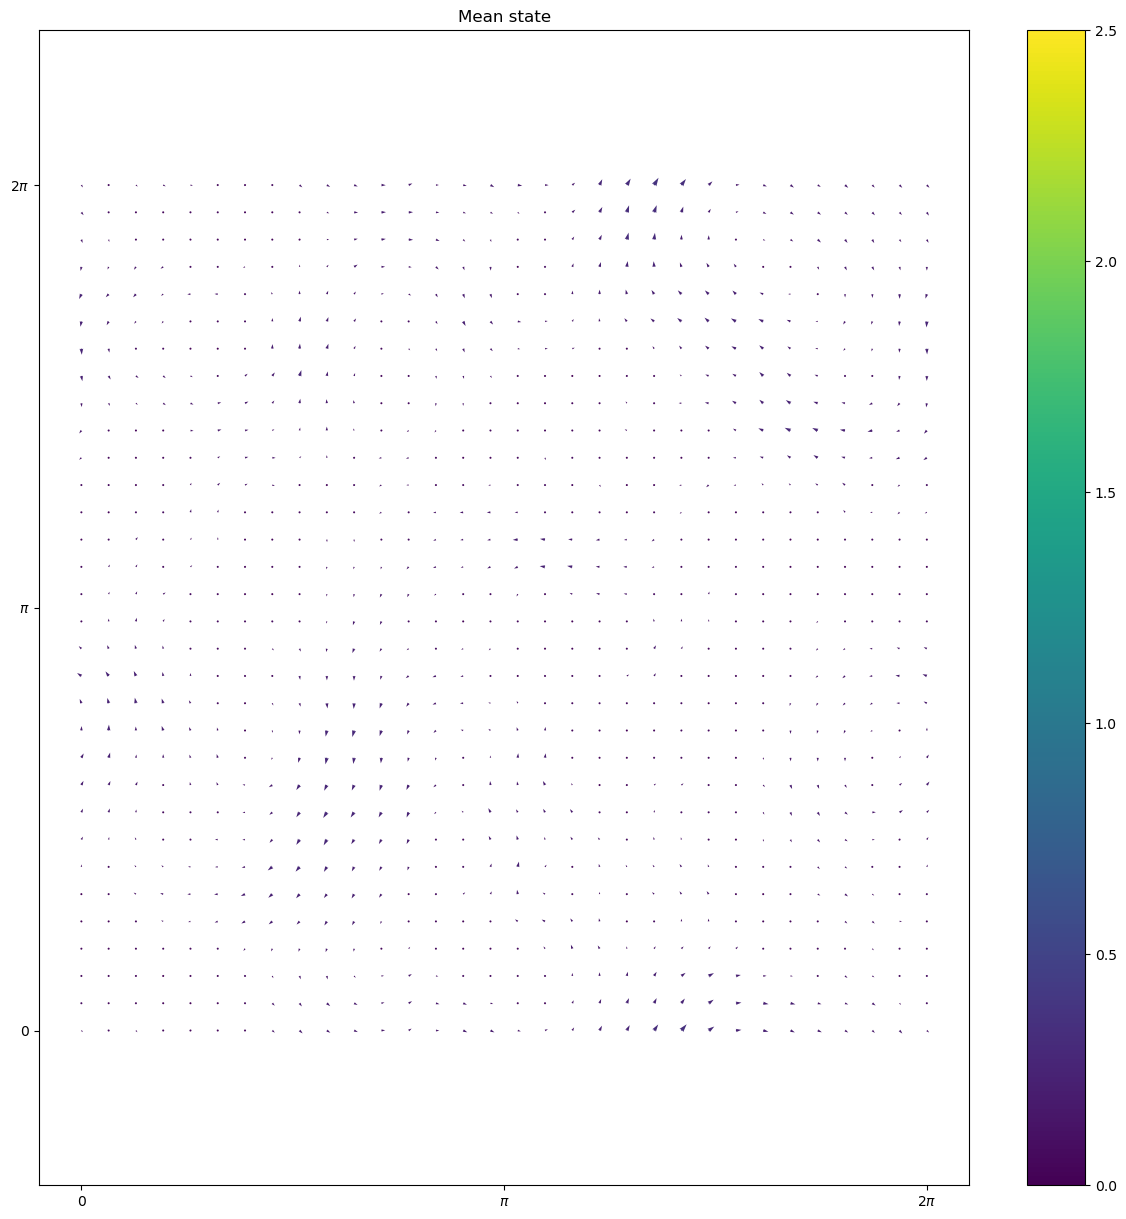

In [30]:
mu_u = np.mean(U, axis=2); mu_v = np.mean(V, axis=2)
print(mu_u.shape)
plot_wind(X, Y, mu_u, mu_v)
plt.title('Mean state')

In [31]:
d = np.empty((U.shape[2], 2*ny*nx))
for _ in range(d.shape[0]):
    d[_, :ny*nx] = (U[:, :, _]-0*mu_u).ravel() # subtract mean
    d[_, ny*nx:] = (V[:, :, _]-0*mu_v).ravel() # subtract mean


In [32]:
B = np.zeros((2*nx*ny, 2*nx*ny))
for i in range(d.shape[1]):
    B[i, i ] = 1.e-3 ## make sure we're diagonally dominant for stability
    for j in range(d.shape[1]):
        # We'll be good and use the unbiased (N-1) form of the sample covariance
        B[i, j] += np.sum(d[:, i]*d[:, j])/(d.shape[0]-1)

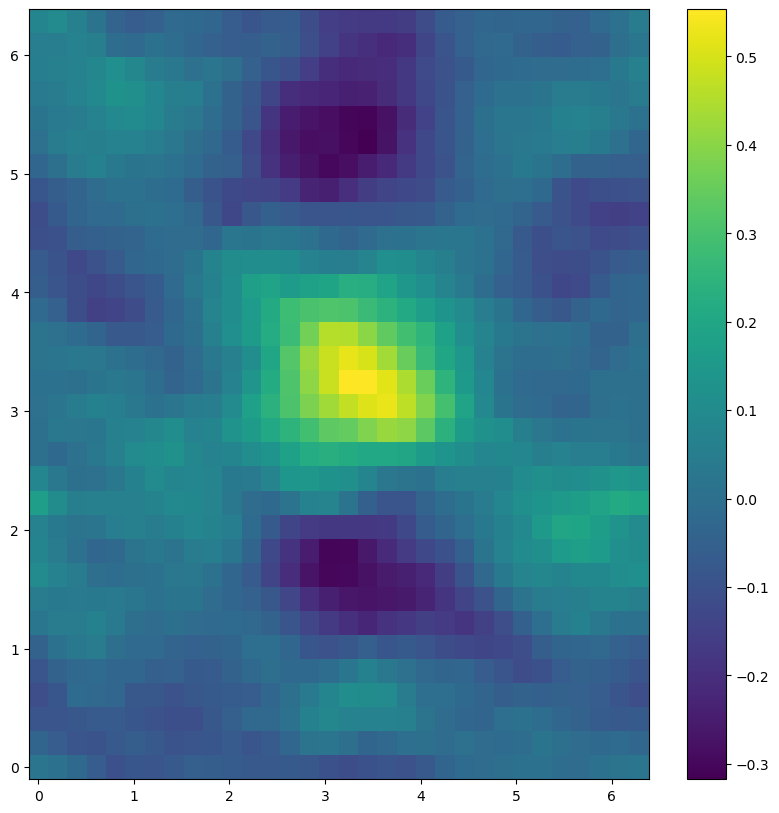

In [33]:
plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, B[ny//2*nx+nx//2, :ny*nx].reshape((ny,nx)), shading='auto')
plt.colorbar()

In [34]:
# define the background (first guess) as the mean state (our "climatology")

x_b = np.empty(2*ny*nx) 
x_b[:ny*nx] = mu_u.ravel(); x_b[ny*nx:] = mu_v.ravel()
# Note the ravel; x is a *vector*

In [35]:
from numpy.linalg import solve


def J(dx, x_b):
    dx_o = y - h(x_b.ravel()+dx)
    dz = solve(B, dx)
    dz_o = solve(R, dx_o)
    out = (dx.T@dz+dx_o.T@dz_o)/2.0
    return out

In [36]:
def dh(x):
    H = np.zeros((2*n_full+n_speed,2*nx*ny))
    u = x[y_loc]
    v = x[ny*nx+y_loc]
    for _ in range(n_full):
        H[_, y_loc[_]] = 1.0
        H[n_full+_, nx*ny+y_loc[_]] = 1.0
    for _ in range(n_speed):
        H[2*n_full+_, y_loc[n_full+_]] = u[n_full+_]/np.sqrt(1.e-8+u[n_full+_]**2+v[n_full+_]**2) # for stability
        H[2*n_full+_, nx*ny+y_loc[n_full+_]] = v[n_full+_]/np.sqrt(1.e-8+u[n_full+_]**2+v[n_full+_]**2) # for stability
    return H

def jac(dx, x_b):
    x = x_b+dx
    dx_o = y - h(x)
    H = dh(x)
    dz = solve(B, dx)
    dz_o = solve(R, dx_o)
    return dz-H.T@dz_o

In [38]:
from scipy.optimize import minimize
delta_x = 0*x_b.ravel()
res = minimize(J, delta_x, args=(x_b), jac=jac, method='L-BFGS-B', tol = 1e-5, options={'maxiter':200, 'disp':False})
print(res.message)
delta_x += res.x


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


In [39]:
# Could also write a steepest descent solver ourselves
# Note this will probably stop early (common for
# operational DA implementations)

from numpy.linalg import norm
from scipy.optimize import line_search

delta_x = 0*x_b.copy()
res = [0.0]
for i in range(100):
    pk = -jac(delta_x, x_b)
    j_dx = lambda x: J(x, x_b)
    jac_dx = lambda x: jac(x, x_b)
    if i%5==0:
        print(f'Step {i}, J(x)={j_dx(delta_x)}')
    res = line_search(j_dx, jac_dx, delta_x, pk, amax=0.5)
    if res[0]:
        delta_x += res[0]*pk
    else:
        print('Diverged')
        break
print(f'final J(x)={j_dx(delta_x):.2f}')

Step 0, J(x)=8706.947625648501
Step 5, J(x)=6781.33461159608
Step 10, J(x)=5830.145986749621
Step 15, J(x)=5055.436559304934
Step 20, J(x)=4437.276953799745
Step 25, J(x)=3933.2200759315306
Step 30, J(x)=3497.9409237859227
Step 35, J(x)=3127.9212739504665
Step 40, J(x)=2791.7978469586674
Step 45, J(x)=2480.194675002769
Step 50, J(x)=2203.931581632626
Step 55, J(x)=1964.966751322597
Step 60, J(x)=1774.373277326821
Step 65, J(x)=1633.571134597641
Step 70, J(x)=1527.654051992787
Step 75, J(x)=1449.9504969445877
Step 80, J(x)=1394.6473873320435
Step 85, J(x)=1351.2228748628609
Step 90, J(x)=1313.8632051416994
Step 95, J(x)=1280.9644826799097
final J(x)=1251.82


In [40]:

# Get analysis
x_a = x_b + delta_x
U_a = x_a[:ny*nx].reshape((ny,nx))
V_a = x_a[ny*nx:].reshape((ny,nx))

Text(0.5, 1.0, 'background state')

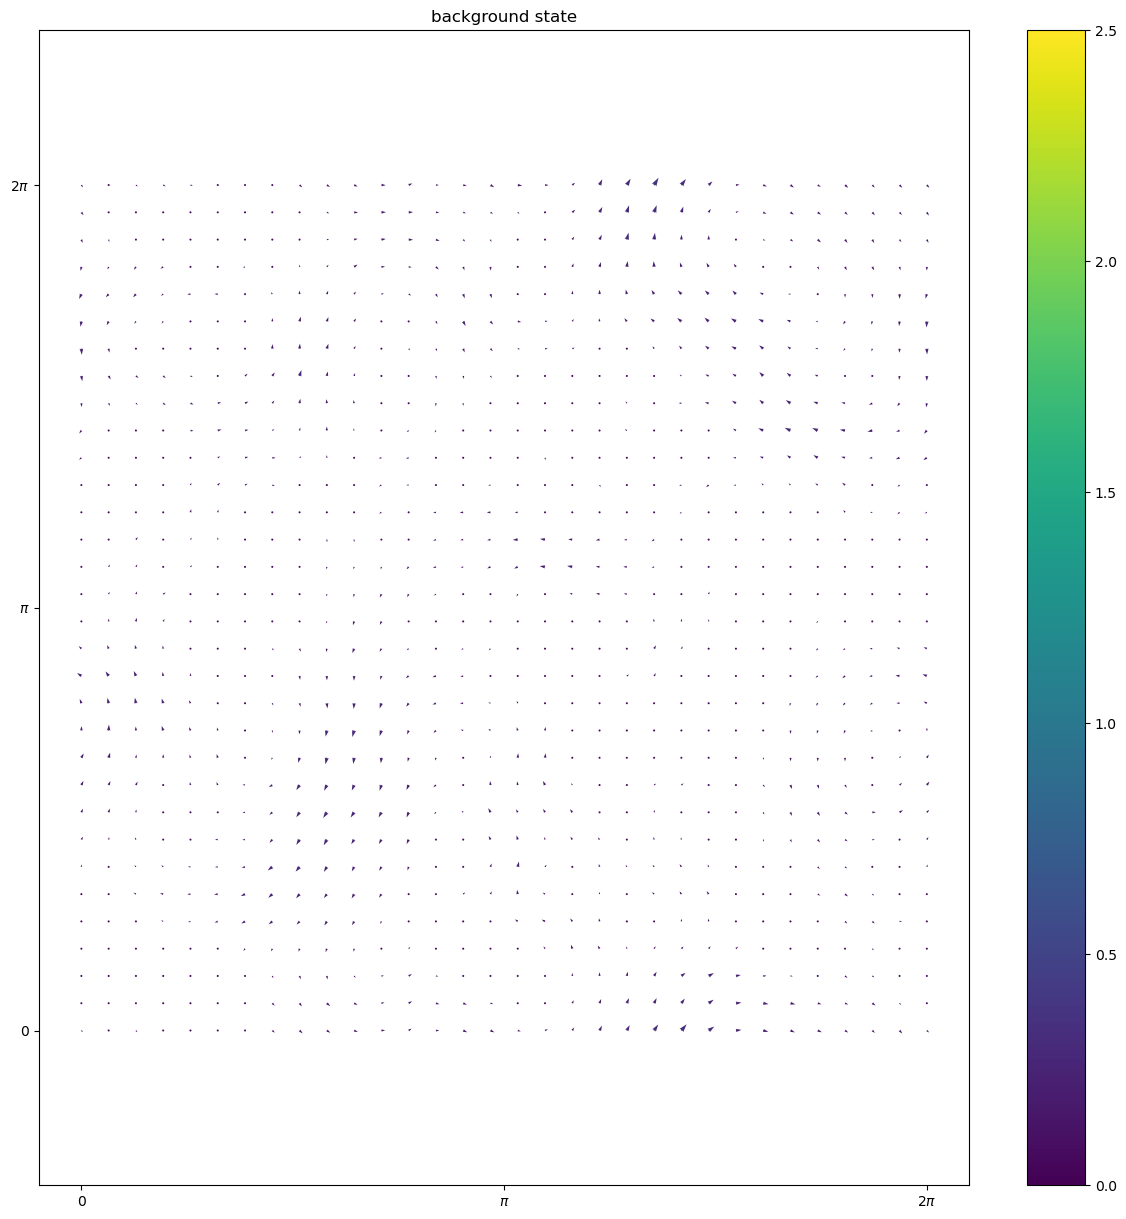

In [41]:
# first-guess - climatography
plot_wind(X, Y, mu_u, mu_v)
plt.title('background state')

Text(0.5, 1.0, 'True state')

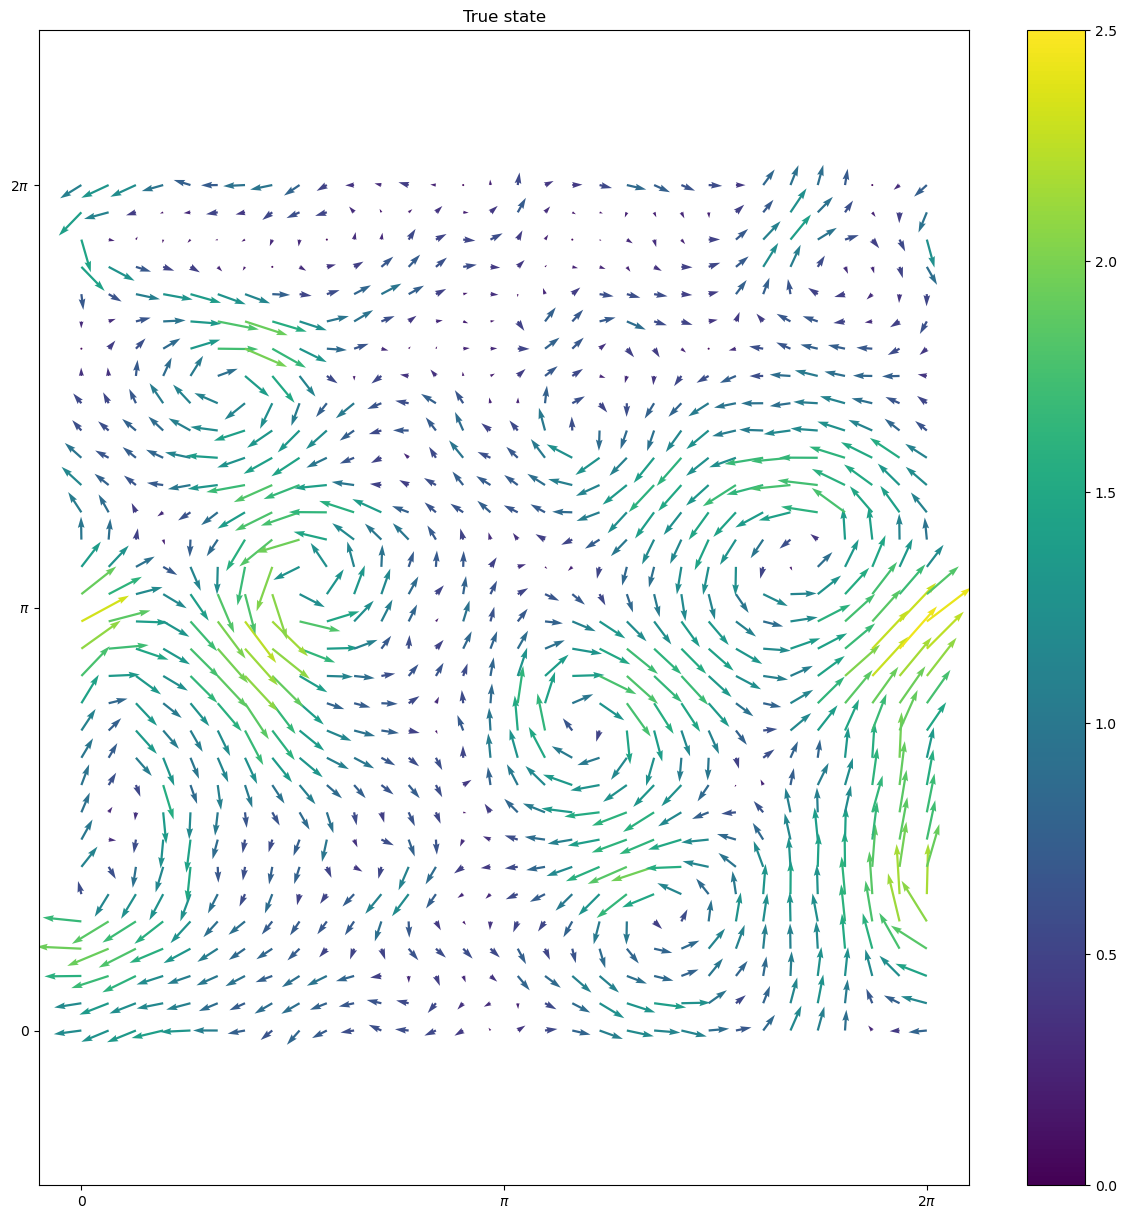

In [42]:
# true state
plot_wind(X, Y, U_t, V_t)
plt.title('True state')

Text(0.5, 1.0, 'Observations')

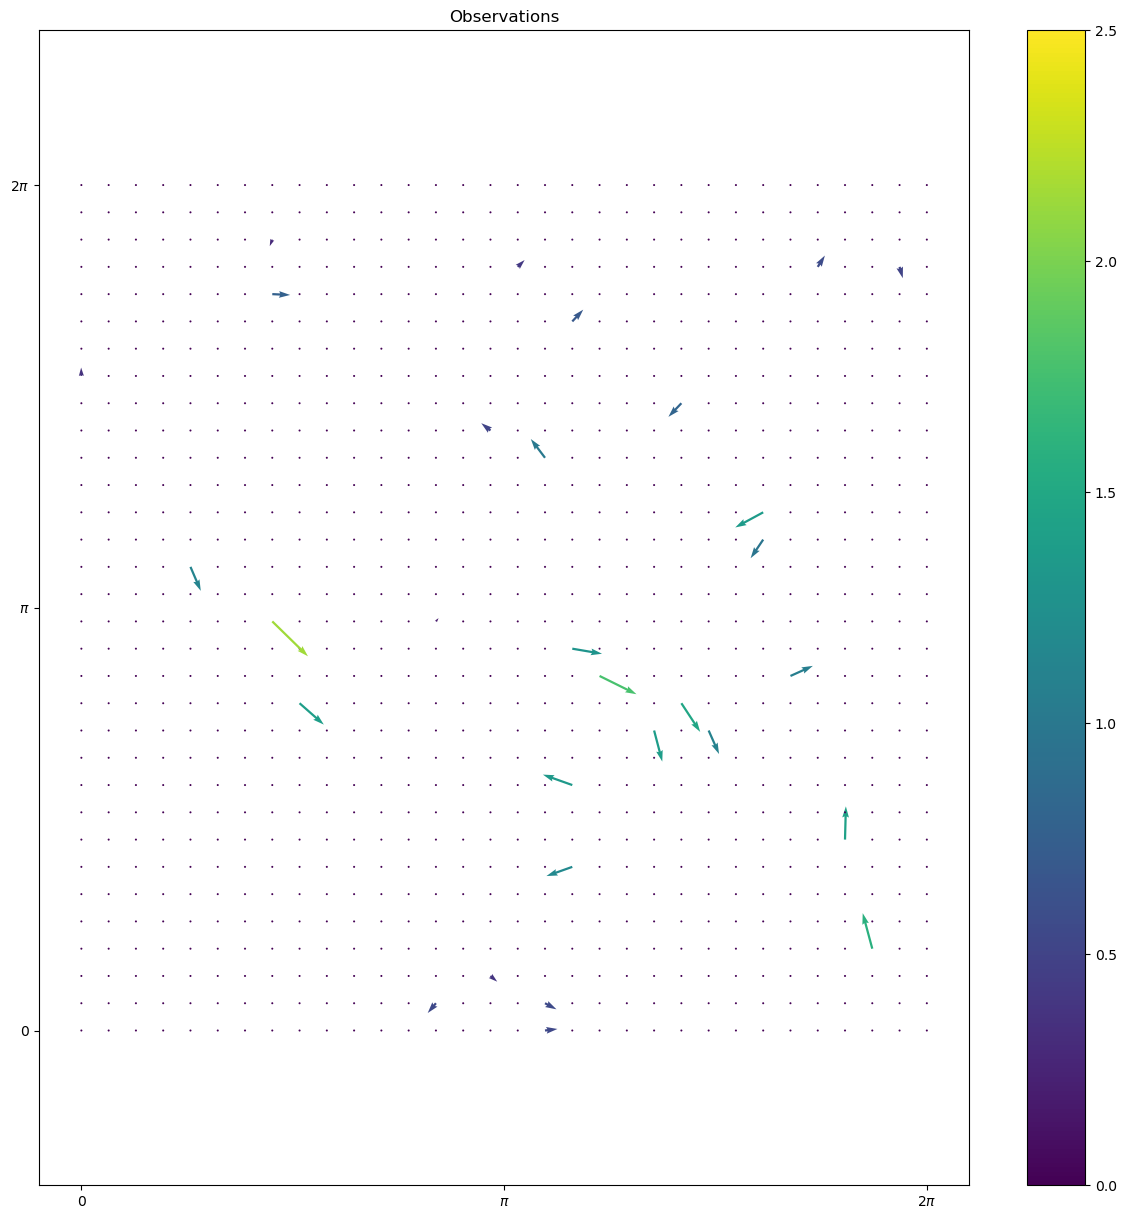

In [43]:
# our observations
plot_wind(X, Y, U_o, V_o)
plt.title('Observations')

J(x_b)=8706.947625648501, J(x_a)=1251.8150724450065


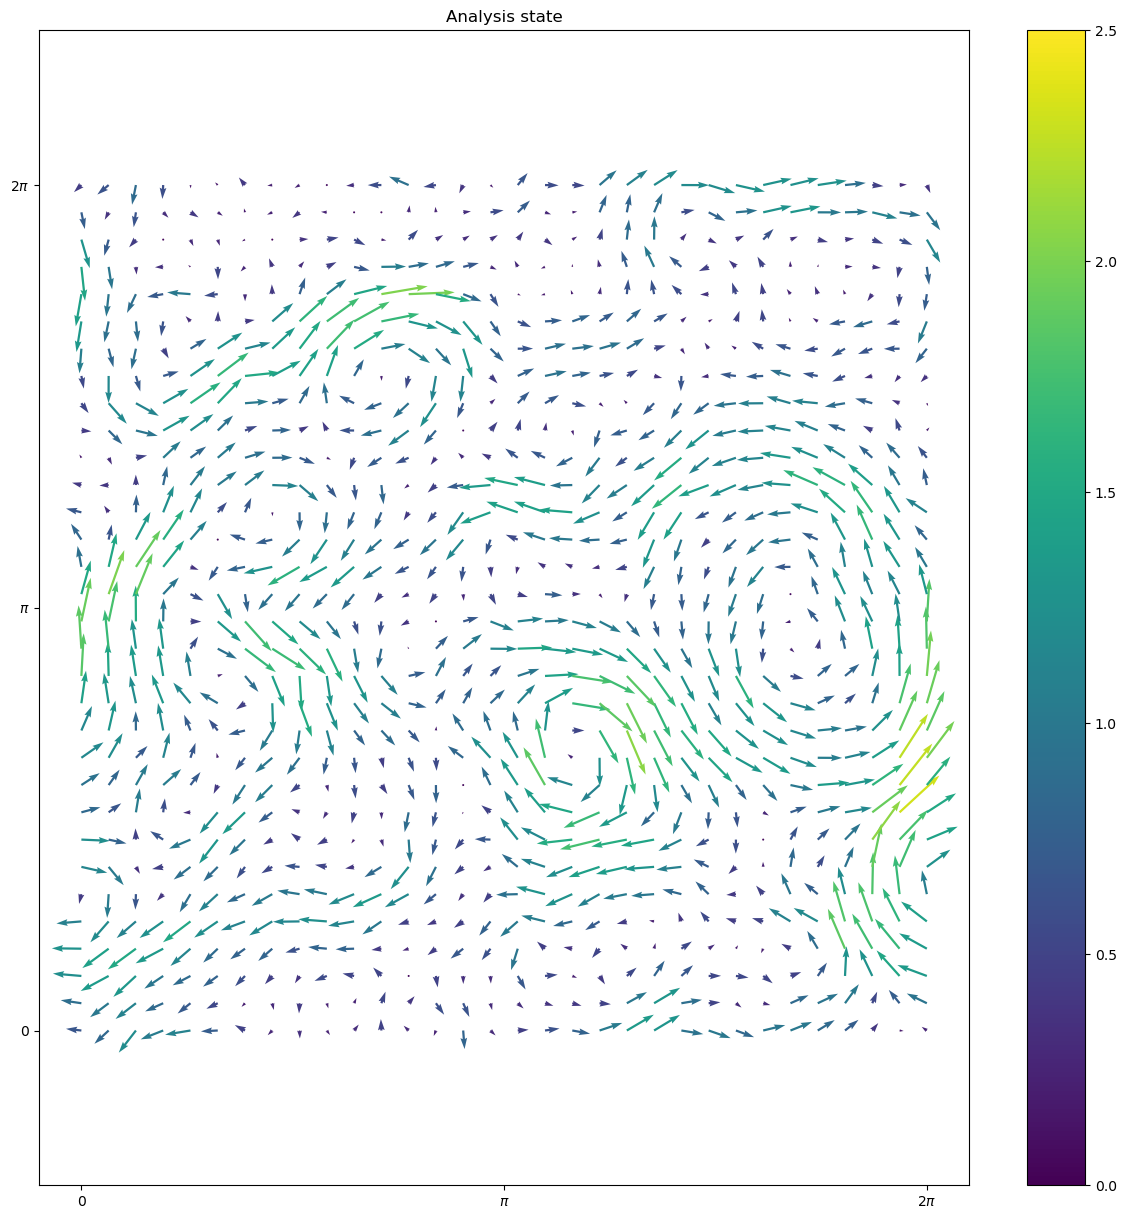

In [44]:
# our analysis
plot_wind(X, Y, U_a, V_a)
plt.title('Analysis state')
print(f'J(x_b)={J(0*x_b, x_b)}, J(x_a)={J(x_a-x_b, x_b)}')

Text(0.5, 1.0, 'Analysis error')

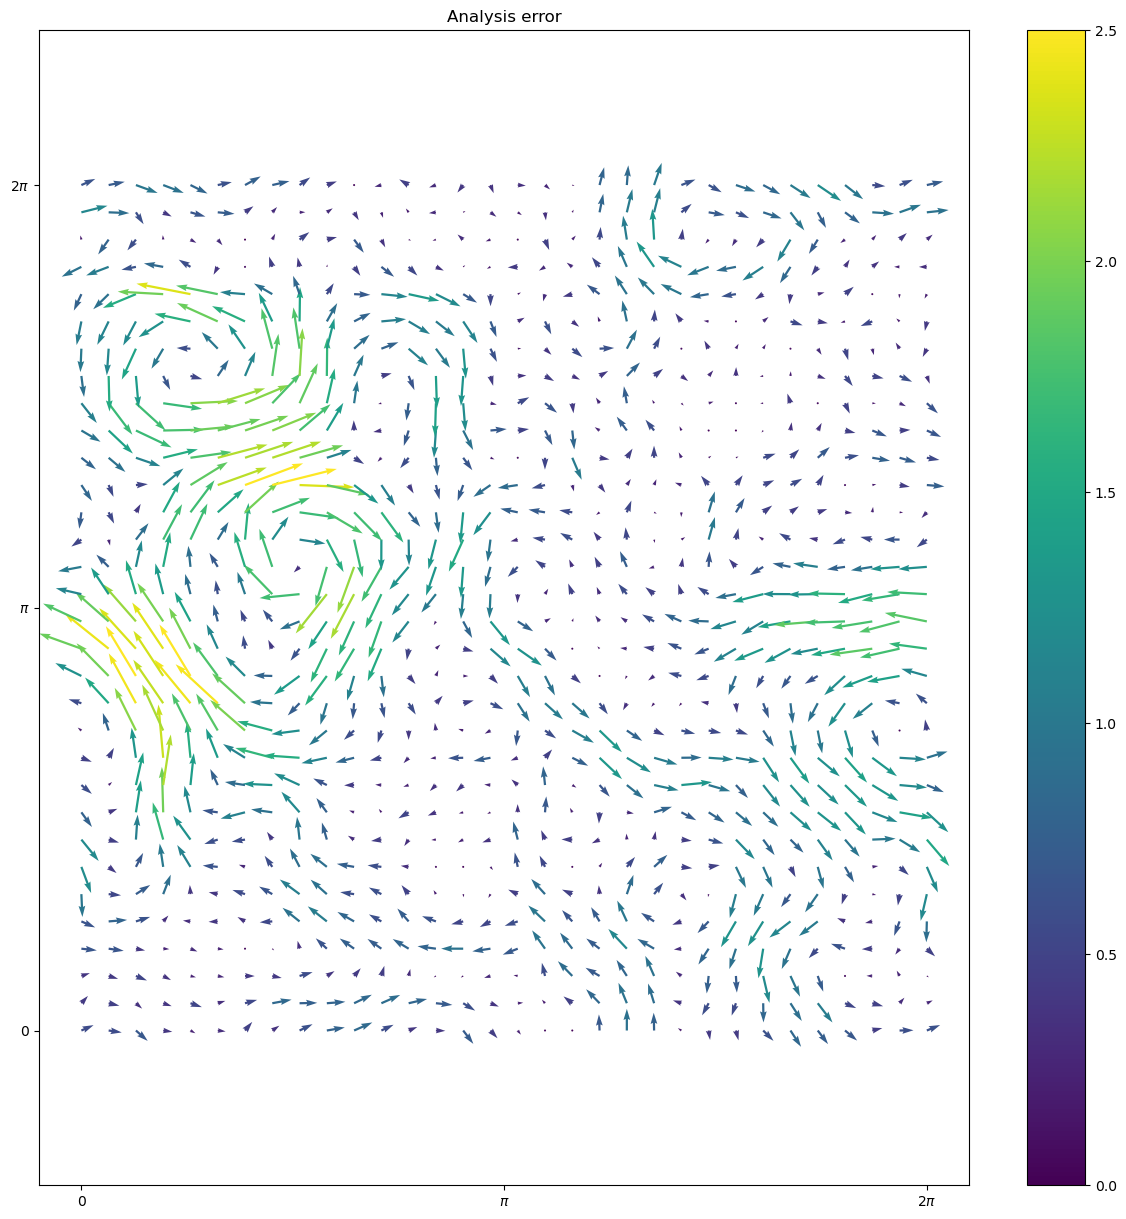

In [45]:
# our error
plot_wind(X, Y, U_a-U_t, V_a-V_t)
plt.title('Analysis error')

#### Good things:
- Can use single $\mathbf{B}$
- Don't need to understand model
- Can apply standard minimization techniques
- Allows nonlinear observations
#### Bad things:
- No time dependence
- Iteration to nonlinear solution usually much more costly than solving a linear equation

## Two names, same outcome

If $\mathbf{h}(\mathbf{x})$ is linear (i.e. $\mathbf{h}(\mathbf{x})=\mathbf{H}\mathbf{x}$)

then for 3D-Var

$$\mathbf{x}_a = \mathbf{x}_b + \left(\mathbf{B}^{-1}+\mathbf{H}^T\mathbf{R}^{-1}\mathbf{H}\right)^{-1}\mathbf{H}^T\mathbf{R}^{-1}[\mathbf{y}-\mathbf{H}\mathbf{x}_b] $$
Actually same as Optimal Interpolation (although it may not look it initially)!

In this case

$$J(\mathbf{e})=\|\mathbf{e}-\mathbf{e}_b\|^2_{\mathbf{B}}+\|\mathbf{H}\mathbf{e}-\mathbf{e}_o\|^2_{\mathbf{R}} $$
for norms

$$\|\mathbf{a}\|^2_{\mathbf{M}}=\mathbf{a}^T\mathbf{M}^{-1}\mathbf{a}$$

Example of statistics based/Tikhonov regularization!

##  Putting time in the assimilation process

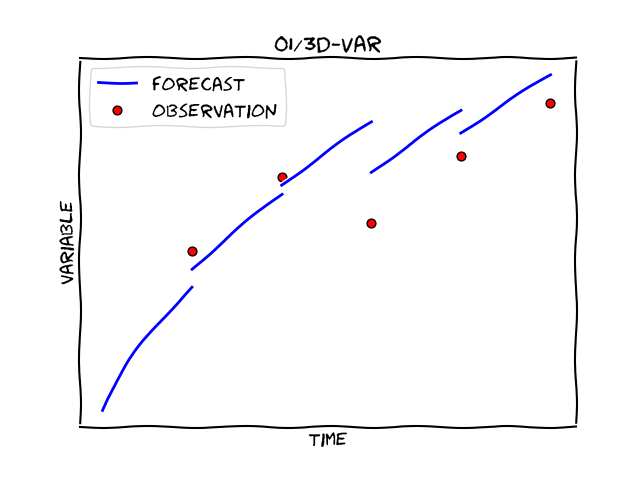

Not making full use of the data!

## The Kalman Filter

- Consider a system with an accurately known, linear equation matrix $\mathbf{M}$  and forcing $\mathbf{f}$ to update $\mathbf{x}_t$ in time:
$$\mathbf{x}^{(k+1)}_t = \mathbf{M}\mathbf{x}^{(k)}_t + \mathbf{f}^(k).$$
- Give guess $\mathbf{x}_a$ at step $k$ forecast is
$$\mathbf{x}^{(k+1)}_b = \mathbf{M}\mathbf{x}^{(k)}_a +\mathbf{f}_b^(k).$$
- error update equation is
$$\mathbf{e}_b^{(k+1)} = \mathbf{M}\mathbf{e}^{(k)}_a +\mathbf{e}_f^{(k)}$$

where $\mathbf{e}_a^{(k)} := \mathbf{x}_a^{(k)}-\mathbf{x}^{(k)}_t$ $\mathbf{e}_f^{(k)} := \mathbf{f}_b^{(k)}-\mathbf{f}^{(k)}$.

- Error covariances go like
$$\mathbf{B}^{k+1} =  \mathbb{E}(\mathbf{e}_b^{k+1}[\mathbf{e}_b^{k+1}]^T) $$
$$\qquad \qquad \qquad= \mathbf{M}\mathbb{E}(\mathbf{e}_a^k[\mathbf{e}_a^k]^T)\mathbf{M}^T+\mathbb{E}(\mathbf{e}_f[\mathbf{e}_f]^T)$$
$$\qquad = \mathbf{M}\mathbf{P}^k\mathbf{M}^T+\mathbf{Q}$$

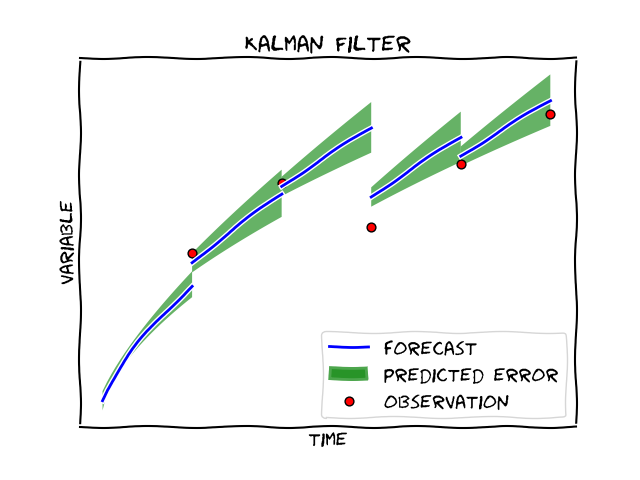

Four stage process
1. Use model to update analysis into  forecast
$$ \mathbf{x}^{k+1}_b = \mathbf{M}\mathbf{x}^k_a+\mathbf{f}_b$$
2. Use model to update analysis error covariance into forecast error covariance
$$\mathbf{B}^{k+1} = \mathbf{M}\mathbf{P}^k\mathbf{M}^T +\mathbf{Q}$$
3. Use observation innovations to (optimally) update forecast into analysis,
$$ \mathbf{x}^{k+1}_a = \mathbf{x}^{k+1}_b + \mathbf{B}^{k+1} \mathbf{H}^T\left( \mathbf{R}^{k+1} + \mathbf{H}\mathbf{B}^{k+1}\mathbf{H}^T\right)^{-1} (\mathbf{y}^{k+1}-\mathbf{H}\mathbf{x}^{k+1}_b).$$
4. Calculate the analysis error covariance.
 $$\mathbf{P}^{k+1} = (\mathbf{I}-\mathbf{B^{k+1}}[\mathbf{H}^{k+1}]^T(\mathbf{R}^{k+1}+\mathbf{H}^{k+1}\mathbf{B}^{k+1}[\mathbf{H}^{k+1}]^T)^{-1}\mathbf{H}^{k+1})\mathbf{B}^{k+1}.$$

#### Good things:
- Should have a highly appropriate $B$ (assuming initialization method is ok)
- Know/can estimate error bounds in forecast
- Most accurate (per MSE) approach if all assumptions hold.
#### Bad things:
- Calculating new $B$ usually **really** costly.
- Information only carried forwards, not backward (in filter).
- Linear $\mathbf{H}$ & $\mathbf{M}$ (can do a bit better here).

- Kalman Filter only goes forwards
- If we assume a normal error distribution, we can also carry information backwards.
- Usually called Kalman smoother.

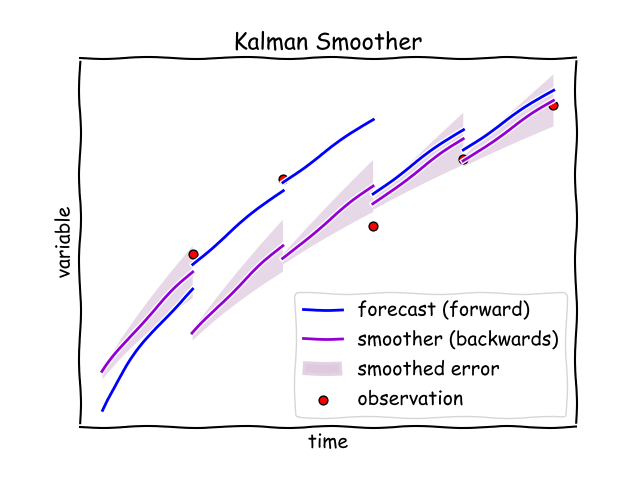

Easily gets expensive. We can try to do things cheaper.

## Temporal Variational Assimilation: 4D-Var

- 4D-Var is time-aware equivalent of 3D-Var method 
- Assuming observation and background errors fGaussian.
- Look for initial state vector, $\mathbf{x}_0$, maximizing the a posteriori likelihood over "time window"

$$ p(\mathbf{x}_0\vert \mathbf{y}) \propto \exp\left(-\frac{(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\sum_i(\mathbf{y}_i-\mathbf{h}_i(\mathbf{x}_i)))^T\mathbf{R}_i^{-1}(\mathbf{y}_i-\mathbf{h}_i(\mathbf{x}_i))}{2}\right),$$
subject to **constraint** that $\mathbf{x}_{i+1} = \mathbf{m}(\mathbf{x}_i, t_i)$.

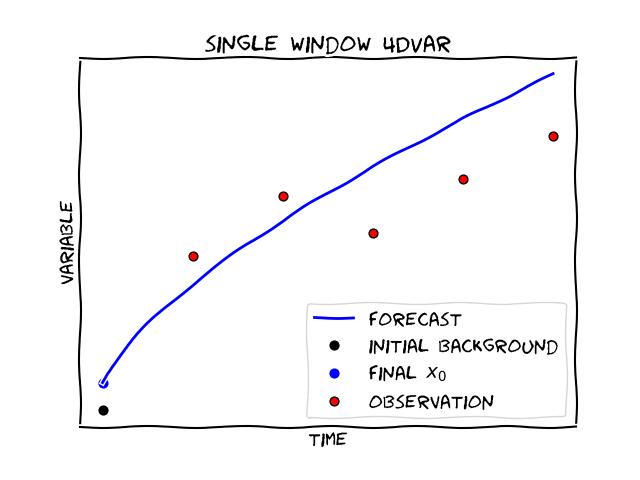

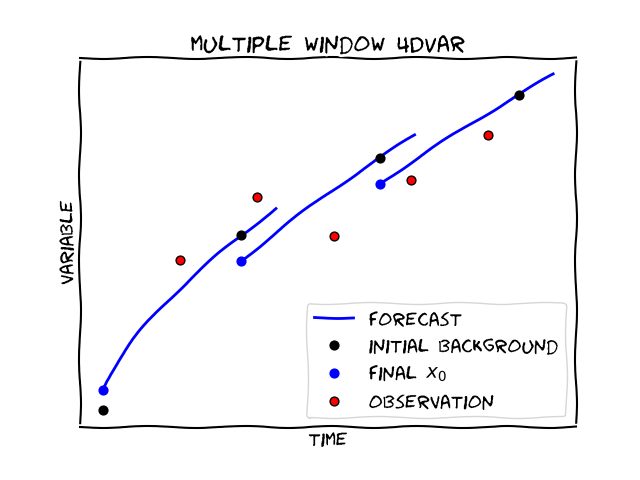

- PDE constrained optimization problem.
- Solution through adjoint methods, as in Stephan's lectures.
- Let's look briefly at the discrete case:

### 4D-Var as constrained optimization

Cost function to minimise ($-\log (p)$) is

$$\mathcal{J}_{ext}= \frac{(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\sum_i(\mathbf{y}_i-\mathbf{h}_i(\mathbf{x}_i)))^T\mathbf{R}_i^{-1}(\mathbf{y}_i-\mathbf{h}_i(\mathbf{x}_i))}{2}$$
$$\qquad\qquad+ \sum_{i=0}^{N-1} \boldsymbol{\lambda}_i^T\left(\mathbf{x}_{i+1}-\mathbf{m}(\mathbf{x}_i, t_i)\right)$$

where we are perturbing the $\mathbf{x}_0$.

Optimality conditions are:

$$\boldsymbol{\lambda_i}: \quad \mathbf{x}_{i+1}- \mathbf{x}_i -\mathbf{m}(\mathbf{x}_i, t_i) =\mathbf{0}$$
$$\mathbf{x}_0: \quad \mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\mathbf{H}_0\mathbf{R}^{-1}(\mathbf{h}_0(\mathbf{x}_0)-\mathbf{y})-\mathbf{M}_{i}^T\boldsymbol{\lambda}_0=\mathbf{0}$$
$$ \mathbf{x}_i: \quad\boldsymbol{\lambda}_{i-1}-\mathbf{M}_{i}^T\boldsymbol{\lambda}_i+\mathbf{H}_{i}^T\mathbf{R}^{-1}_{i}(\mathbf{h}_{i}(\mathbf{x}_{i})-\mathbf{y}_{i}))=\mathbf{0} $$
$$ \mathbf{x}_N: \quad\boldsymbol{\lambda}_{N-1}+\mathbf{H}_{N}^T\mathbf{R}^{-1}_{N}(\mathbf{h}_{N}(\mathbf{x}_{N})-\mathbf{y}_{N}))=\mathbf{0} $$

where $\left[\mathbf{M}_k\right]_{ij}  = \frac{\partial [\mathbf{m}_k(\mathbf{x}_k, t_k)]_i}{\partial [\mathbf{x}_k]_j}$ is the tangent linearization of the nonlinear forward model.

- If model & obervation were linear in $\mathbf{x}$, could start at $\boldsymbol{\lambda}_{N-1}$, solve adjoint backwards to $\boldsymbol{\lambda}_0$ and then find optimal $\mathbf{x}_0$ in one go.
- Since it usually isn't, can iterate in a gradient based nonlinear solver _for_ $\mathbf{x}_0$ instead, as in previous lecture.
- This is "just" PDE constrained optimization for our initial condition, with a cost/penalty function as the maximum _a posteriori_ estimate (MAP) for Gaussian errors.

If the model & observation operator is linear, and we just have one observation at the end, then:
$$\quad\boldsymbol{\lambda}_{N-1}=-\mathbf{H}_{N}^T\mathbf{R}^{-1}_{N}(\mathbf{h}_{N}(\mathbf{x}_{N})-\mathbf{y}_{N})$$
$$\lambda_{N-i} = -\left(\prod_{j=N-i}^{N-1}\mathbf{M}_{j}^T\right)\mathbf{H}_{N}^T\mathbf{R}^{-1}_{N}\left(\mathbf{H}_{N}\left(\prod_{k=0}^{N-1}\mathbf{M}_{k}\right)\mathbf{x}_{0}-\mathbf{y}_{N}\right).$$

so that the optimal initial condition satisfies

$$\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\left(\prod_{j=0}^{N-1}\mathbf{M}_{j}^T\right)\mathbf{H}_{N}^T\mathbf{R}^{-1}_{N}\left(\mathbf{H}_{N}\left(\prod_{k=0}^{N-1}\mathbf{M}_{k}\right)\mathbf{x}_{0}-\mathbf{y}_{N}\right)-=\mathbf{0}$$

Alternatively defining $\overline{\mathbf{x}}_N:=\left(\prod_{j=0}^{N-1}\mathbf{M}_{j}\right)\mathbf{x}_b$, $\delta\mathbf{x}_N := \left(\prod_{j=0}^{N-1}\mathbf{M}_{j}\right)\left(\mathbf{x}_0-\mathbf{x}_b\right)$

$$\left(\prod_{j=0}^{N-1}\mathbf{M}_{j}^T\right)^{-1}\mathbf{B}^{-1}\left(\prod_{j=0}^{N-1}\mathbf{M}_{j}\right)^{-1}\delta \mathbf{x}_N+\mathbf{H}_{N}^T\mathbf{R}^{-1}_{N}\left(\mathbf{H}_{N}\left(\overline{\mathbf{x}}_{N}+\delta\mathbf{x}_N\right)-\mathbf{y}_{N}\right)=\mathbf{0}$$

Solving the first equation for $\mathbf{x}_0$
$$ \mathbf{x}_0 = \mathbf{x}_b + \left(\mathbf{B}^{-1}+\left(\prod_{j=0}^{N-1}\mathbf{M}_{j}^T\right)\mathbf{H}_{N}^T\mathbf{R}^{-1}_{N}\mathbf{H}_{N}\left(\prod_{k=0}^{N-1}\mathbf{M}_{k}\right)\right)^{-1}\left(\mathbf{y}_{N}-\mathbf{H}_{N}\left(\prod_{k=0}^{N-1}\mathbf{M}_{k}\right)\mathbf{x}_{b}\right)$$

update goes backwards like Kalman smoother.

Looking at update at time N, it is in form
$$\delta \mathbf{x}_N = \left( \left(\mathbf{B}^{N}\right)^{-1} + \mathbf{H}_{N}^T\mathbf{R}^{-1}_{N}\mathbf{H}_{N}^T\right) \mathbf{H}_{N}^T\mathbf{R}^{-1} (\mathbf{y}-\mathbf{H}\overline{\mathbf{x}}_N) $$
the same as Kalman filter would give, i.e. method implicitly calculates
$$\mathbf{B}^{N} = \left(\left(\prod_{j=0}^{N-1}\mathbf{M}_{j}\right)\mathbf{B}\left(\prod_{k=0}^{N-1}\mathbf{M}_{k}^T\right)\right)$$
implicitly.

For a concrete example, let's consider the Lorentz equation, discretized by forward Euler:

$$ x^{(n+1)} = x^{(n)} - \sigma \Delta t x^{(n)} + \sigma \Delta t y^{(n)}$$
$$ y^{(n+1)} = y^{(n)} - x^{(n)} z^{(n)} \Delta t + r x^{(n)} \Delta t - y^{(n)} \Delta t$$
$$ z^{(n+1)} = z^{(n)} + x^{(n)} y{(n)} \Delta t - b z^{(n)} \Delta t$$
where $\Delta t$ is the time step and $n$ is the time index.

The tangent liner model, $M(\mathbf{x})$ is

$$ M^{(k)}_{ij} = \frac{\partial \mathbf{m}(\mathbf{x})_i}{\partial x_j}$$

i.e.,

$$ M^{(k)} = \left[
\begin{array}{ccc}
1-\sigma \Delta t & \sigma \Delta t & 0 \\
(\rho-z^{(k)}) \Delta t & 1- \Delta t & -x^{(k)} \Delta t \\
y^{(k)} \Delta t & x^{(k)} \Delta t & 1-\beta \Delta t
\end{array}\right]$$

and the adjoint model is it's transpose. Code requires building cost funcion, Jacobian function and minimizing. See Jupyter book version for an example.

#### Good things:
- Implicitly improves/updates $B$ over course of time window (see exercises).
- Uses all information in time window
- Cheaper than equivalent Kalman filter
#### Bad things:
- New $B$ not saved/accessible.
- Backing out individual error bounds significant extra work
- Costlier that OI/3D-Var
- Adjointing is often hard, assumes model is differentiable.

### Extended Kalman Filter

- We can also extend the Kalman Filter to the nonlinear case by linearizing the model appropriately:
- Assume covariances update via linearized model, $M$ state by nonlinear model $m$.

These turn up in the (optional) exercises, or see the full notes.

## The Ensemble Kalman Filter

- The error covariance matrix is hard to update (and store) in high dimensions.
- Weather models have a lot of dimensions, but not all important in explaining variance.
- Dimension reduction? (PCA, SVD, etc.)
- Ensemble Kalman Filter (EnKF) uses a Monte Carlo method to estimate the error covariance matrix.





- Rather than calculating $B$ with statistics, can calculate forward for multiple state instances & use sample mean, covariance, etc.
$$\overline{\mathbf{x}}_b^{k+1}  = \frac{1}{N}\sum_{i=1}^{N}\mathbf{x}_a^{(i)}\approx \mathbf{\mu},$$
$$\mathcal{P}^{k+1}:= \frac{1}{N-1} \sum_{i=1}^N (\mathbf{x}_b^{(i)}-\overline{\mathbf{x}}_b)(\mathbf{x}^{(i)}_b-\overline{\mathbf{x}}_b)^T\approx \mathbf{P}.$$
- Use OI approach (with $\mathcal{P}$) to update data for each member instance only.
- Cheap (but sometimes inaccurate) for a small sample set.
- No need to modify model/ write down adjoint equations.
- Implementations add noise to sample members to avoid filter collapse/divergence.

In [46]:
# trivial Ensemble Kalman filter for Lorenz attractor
from lorenz import lorenz_model, ensemble_lorenz_model

x0 = 5*np.ones(3)
t = np.linspace(0, 20, 1001)

x_t = lorenz_model(x0, t)

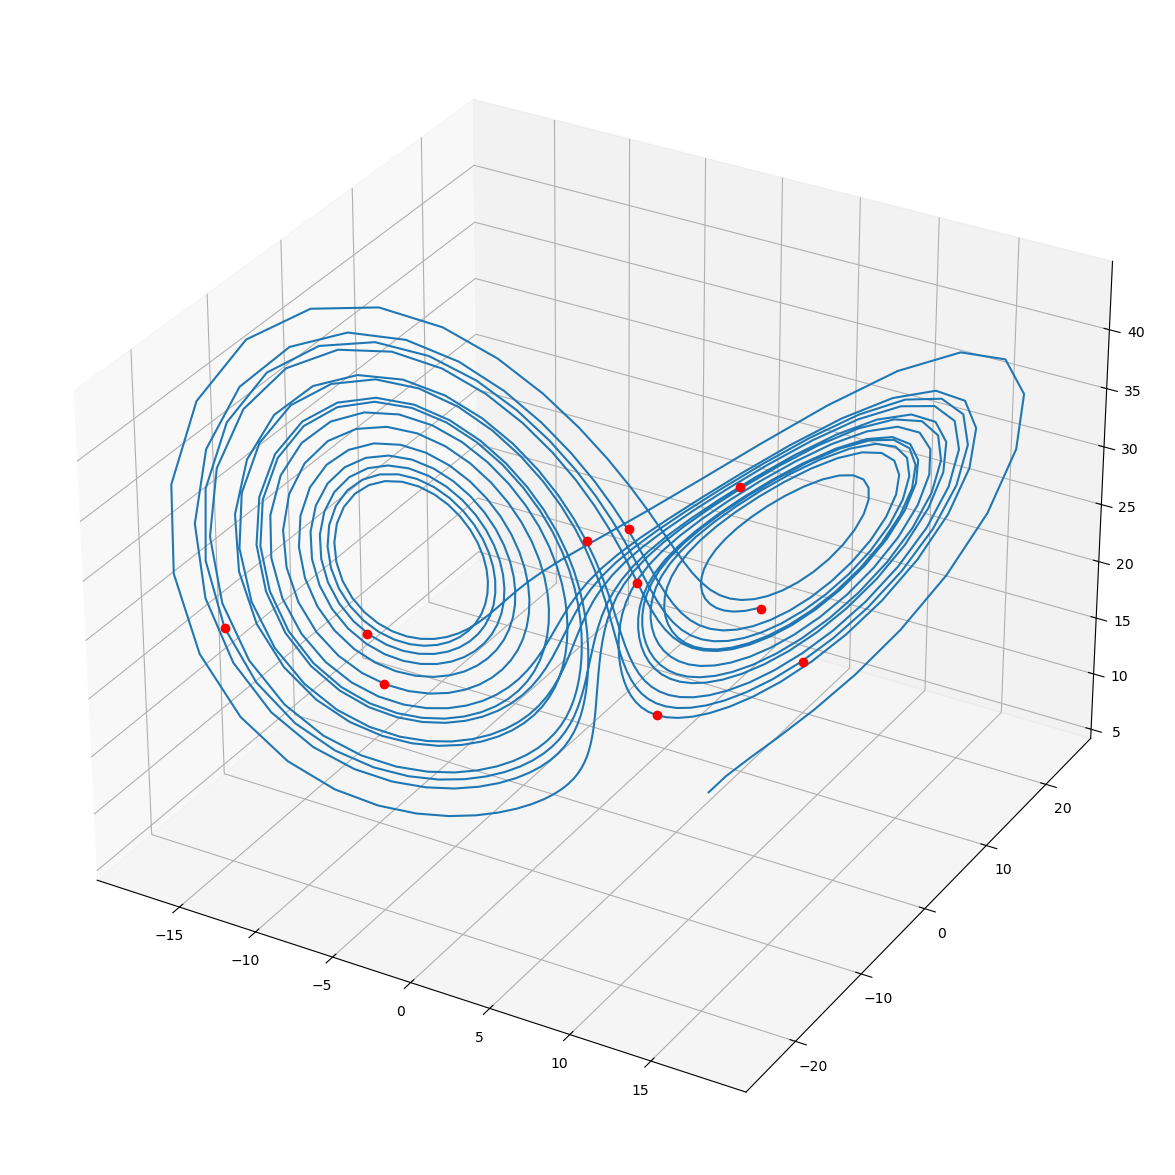

In [47]:

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*x_t[:,0:3].T)

H =np.zeros((1, 3))
H[0, 0] = 1

y = H@x_t[100::100, :].T 
y += np.random.normal(0, 0.1, y.shape)


plt.plot(y.ravel(), *x_t[100::100, 1:].T , 'ro');

In [48]:
from scipy.linalg import inv

N = 10
sigma_r = 0.1

x_b0 = 5*np.ones(3) + np.random.normal(0, 0.5, 3)
X_b0 = np.tile(x_b0, (N, 1)).T + np.random.normal(0, 0.05, (3, N))

X_b = np.empty([len(t), 3, N])


def C(X):
    """Estimate Covariance from ensemble."""
    Xmean = np.mean(X, axis=1)
    A = X - np.tile(Xmean, (N, 1)).T
    return A.dot(A.T)/(N-1)

X_b [:101, ...] = ensemble_lorenz_model(X_b0, t[:101])
X_f = ensemble_lorenz_model(X_b0, t)

In [49]:
# Integrate Kalman system, assimilating observations of $x$
# using ensemble Kalman filter.

for i in range(1, 10):
    # perturb ensemble observations based on error estimate
    Z = np.tile(y[:,i-1], (1, 1)).T - H@(X_b[i*100, :, :]) + np.random.normal(0, sigma_r, (1, N))
    B = C(X_b[i*100, :, :])

    # Calculate optimal gain
    K = B@H.T*inv(H@B@H.T+sigma_r**2)

    # assimilate
    X_a = X_b[i*100, :, :] + K@Z

    # integrate ensemble up to next observation
    X_b[i*100:(i+1)*100+1, ...] = ensemble_lorenz_model(X_a, t[i*100:(i+1)*100+1])

t_y=0

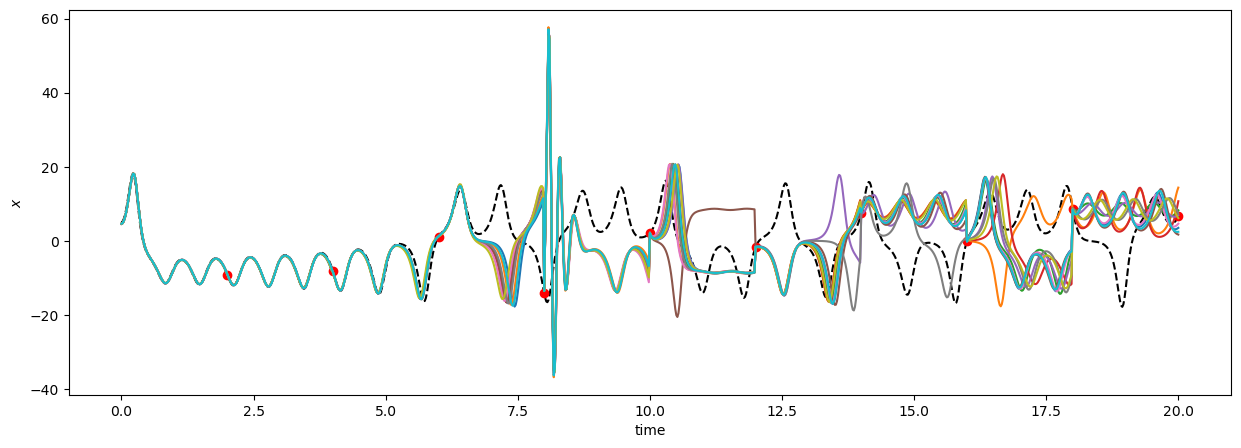

In [50]:
plt.figure(figsize=(15,5))
plt.plot(t, x_t[:, 0], 'k--')
plt.plot(t[100::100], y.ravel(),'ro')
plt.plot(t, X_b[:, 0,],)
plt.ylabel('$x$')
plt.xlabel('time');

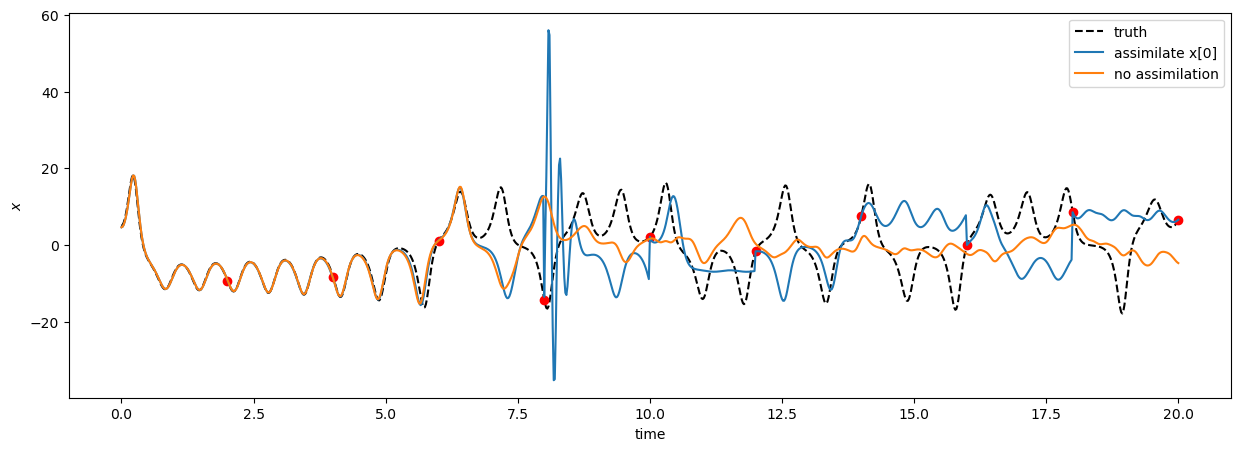

In [51]:
plt.figure(figsize=(15,5))
plt.plot(t, x_t[:, 0], 'k--', label='truth')
plt.plot(t[100::100], y.ravel(),'ro')
plt.plot(t, np.mean(X_b[:, 0, :], axis=1), label='assimilate x[0]')
plt.plot(t, np.mean(X_f[:, 0, :], axis=1), label='no assimilation')
plt.ylabel('$x$')
plt.xlabel('time')
plt.legend();

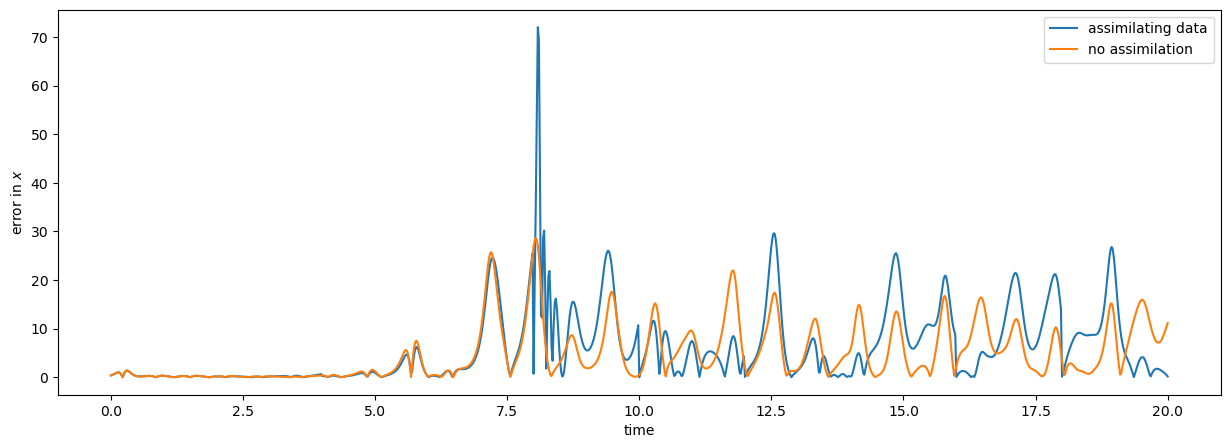

In [52]:
plt.figure(figsize=(15,5))
plt.plot(t, (abs(np.mean(X_b[:, 0, :], axis=1)-x_t[:, 0])), label='assimilating data')
plt.plot(t, (abs(np.mean(X_f[:, 0, :], axis=1)-x_t[:, 0])), label='no assimilation')
plt.ylabel('error in $x$')
plt.xlabel('time')
plt.legend()

### Modern operational assimilation

- Gold standard often combines ensemble methods (to update $\mathbf{B}$) and variational approaches (due to lower operatinge costs & higher speed).
- Short term, high resolution deterministic forecasts tend towards [4D-Var](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3737) or hybrid methods.
- Long term, lower resolution probabilistic forecasts tend towards [ensemble methods](https://www.ecmwf.int/en/about/media-centre/focus/2022/30-years-ensemble-forecasting-ecmwf).

### You should now:

- Have revised some key areas of probability
- Be able to recognise
 - Optimal Interpolation
 - 3D-Var
 - standard Kalman Filter
 - strong constraint 4D-Var
 - the Ensemble Kalman Filter (EnKF)
- Have some idea of their properties and usage.

### Any questions?